<a href="https://colab.research.google.com/github/pqhunter15/LendingClubModeling/blob/main/lending_club_pqh_process_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# conda create -n lending_club pyod scikit-learn pandas pyarrow scipy matplotlib numpy seaborn shap xgboost ipykernel

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure full column display in Jupyter
pd.set_option("display.width", 300)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", 50)   # prevent wrapping, truncate >50 chars

# Loading Data

In [ ]:

# GitHub raw file URL
sample_url = "https://github.com/rfox12-edu/p2p-lending/raw/refs/heads/main/sample.parquet?download="
full_url = "https://github.com/rfox12-edu/p2p-lending/raw/refs/heads/main/accepted_2007_to_2018Q3.parquet?download="

# Read the Parquet file into a DataFrame
df = pd.read_parquet(sample_url, engine="pyarrow")

# Preview the first few rows
print(df.head(30))
print("Rows and columns: ", df.shape)


           id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment grade sub_grade                               emp_title emp_length home_ownership  annual_inc verification_status   issue_d         loan_status pymnt_plan  \
0   107843697        NaN     5000.0       5000.0           5000.0   36 months      8.24       157.24     B        B1                 Field Services Instaler  10+ years       MORTGAGE     54000.0     Source Verified  May-2017          Fully Paid          n   
1    55289858        NaN     9975.0       9975.0           9975.0   36 months     20.99       375.76     E        E5                     Corrections Officer  10+ years           RENT     65878.0            Verified  Jul-2015          Fully Paid          n   
2   121265952        NaN    28050.0      28050.0          28050.0   60 months     11.99       623.82     B        B5                 staff hardware engineer   < 1 year       MORTGAGE    113000.0        Not Verified  Oct-201

# Inspect / Remove Data

## Remove ID Data

In [ ]:
print("Rows and columns: ", df.shape)
drop_columns = [
    # Empty / Metadata
    "id", "member_id", "url",
]
df.drop(columns=drop_columns, inplace=True)
print("Rows and columns: ", df.shape)

Rows and columns:  (20000, 151)
Rows and columns:  (20000, 148)


## Remove Joint Application Data   

In [ ]:
# Analyze the distribution of application types (Joint vs Individual) and their corresponding loan statuses
pd.crosstab(df['application_type'], df['loan_status'])

loan_status       Charged Off  Current  Does not meet the credit policy. Status:Charged Off  Does not meet the credit policy. Status:Fully Paid  Fully Paid  In Grace Period  Late (16-30 days)  Late (31-120 days)
application_type                                                                                                                                                                                                   
Individual               2335     6937                                                  7                                                   19         9332              108                 47                 189
Joint App                  55      774                                                  0                                                    0          159                9                  4                  25

In [ ]:
print("Rows and columns: ", df.shape)
df.drop(df[df["application_type"] == "Joint App"].index, inplace=True)
drop_columns = [
    # Joint applications
    "application_type", "annual_inc_joint", "dti_joint", "verification_status_joint", "revol_bal_joint",
    "sec_app_fico_range_low", "sec_app_fico_range_high", "sec_app_earliest_cr_line", "sec_app_inq_last_6mths",
    "sec_app_mort_acc", "sec_app_open_acc", "sec_app_revol_util", "sec_app_open_act_il",
    "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med", "sec_app_mths_since_last_major_derog"
]
df.drop(columns=drop_columns, inplace=True)
print("Rows and columns: ", df.shape)

Rows and columns:  (20000, 148)
Rows and columns:  (18974, 131)


## Remove Hardship & Settlement Data

In [ ]:
print("Rows and columns: ", df.shape)
drop_columns = [
    # Hardship & Settlement
    "hardship_flag", "hardship_type", "hardship_reason", "hardship_status",
    "deferral_term", "hardship_amount", "hardship_start_date",
    "hardship_end_date", "payment_plan_start_date", "hardship_length",
    "hardship_dpd", "hardship_loan_status",
    "orig_projected_additional_accrued_interest",
    "hardship_payoff_balance_amount", "hardship_last_payment_amount",
    "disbursement_method", "debt_settlement_flag",
    "debt_settlement_flag_date", "settlement_status", "settlement_amount", "settlement_date", "settlement_percentage", "settlement_term"
]
df.drop(columns=drop_columns, inplace=True)
print("Rows and columns: ", df.shape)

Rows and columns:  (18974, 131)
Rows and columns:  (18974, 108)


## Analyze Missing Values & Data Types

In [ ]:
def truncate_val(val, maxlen=30):
    """Truncate strings or repr of values to maxlen."""
    if isinstance(val, str):
        return (val[:maxlen] + "…") if len(val) > maxlen else val
    else:
        sval = str(val)
        return (sval[:maxlen] + "…") if len(sval) > maxlen else sval

summary = pd.DataFrame({
    "dtype": df.dtypes,
    "missing_pct": df.isna().mean() * 100,
    "n_unique": df.nunique(dropna=True),
    "example": df.apply(lambda x: [truncate_val(v) for v in x.dropna().unique()[:3]])
})

summary = summary.reset_index().rename(columns={"index": "column"})

print(summary)


                             column    dtype  missing_pct  n_unique                                            example
0                         loan_amnt  float64     0.000000      1075                          [5000.0, 9975.0, 25000.0]
1                       funded_amnt  float64     0.000000      1080                          [5000.0, 9975.0, 25000.0]
2                   funded_amnt_inv  float64     0.000000      1237                          [5000.0, 9975.0, 25000.0]
3                              term   object     0.000000         2                           [ 36 months,  60 months]
4                          int_rate  float64     0.000000       463                               [8.24, 20.99, 12.99]
5                       installment  float64     0.000000     10061                            [157.24, 375.76, 568.7]
6                             grade   object     0.000000         7                                          [B, E, A]
7                         sub_grade   object    

In [ ]:
# policy_code only has a single value, should be removed...
df.drop(columns="policy_code", inplace=True, errors="ignore")


## Inspect & Handle Date Columns

In [ ]:
# Parse dates safely
df["issue_d_dt"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")
df["earliest_cr_line_dt"] = pd.to_datetime(df["earliest_cr_line"], format="%b-%Y", errors="coerce")
df["last_pymnt_d_dt"] = pd.to_datetime(df.get("last_pymnt_d"), format="%b-%Y", errors="coerce")
df["next_pymnt_d_dt"] = pd.to_datetime(df.get("next_pymnt_d"), format="%b-%Y", errors="coerce")
df["last_credit_pull_d_dt"] = pd.to_datetime(df.get("last_credit_pull_d"), format="%b-%Y", errors="coerce")

In [ ]:
counts = (
    df["issue_d_dt"]
    .value_counts()
    .sort_index()
    .to_frame("count")
    .assign(pct=lambda x: (x["count"] / len(df) * 100).round(2))
    .reset_index()
    .rename(columns={"index": "issue_d_dt"})
)

print(counts)


    issue_d_dt  count   pct
0   2007-11-01      1  0.01
1   2007-12-01      1  0.01
2   2008-01-01      4  0.02
3   2008-02-01      3  0.02
4   2008-03-01      4  0.02
5   2008-04-01      2  0.01
6   2008-06-01      1  0.01
7   2008-07-01      1  0.01
8   2008-09-01      2  0.01
9   2008-10-01      2  0.01
10  2008-11-01      4  0.02
11  2008-12-01      2  0.01
12  2009-01-01      4  0.02
13  2009-02-01      3  0.02
14  2009-03-01      8  0.04
15  2009-04-01      4  0.02
16  2009-05-01      2  0.01
17  2009-06-01      7  0.04
18  2009-07-01      3  0.02
19  2009-08-01      4  0.02
20  2009-09-01      7  0.04
21  2009-10-01      9  0.05
22  2009-11-01      4  0.02
23  2009-12-01      4  0.02
24  2010-01-01      6  0.03
25  2010-02-01      5  0.03
26  2010-03-01      9  0.05
27  2010-04-01     10  0.05
28  2010-05-01      7  0.04
29  2010-06-01     11  0.06
30  2010-07-01      5  0.03
31  2010-08-01      8  0.04
32  2010-09-01      7  0.04
33  2010-10-01      7  0.04
34  2010-11-01      

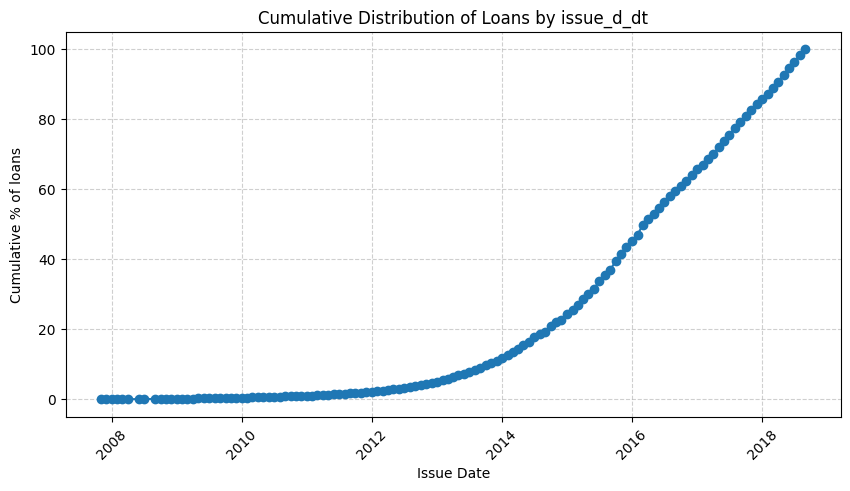

In [ ]:
# Add cumulative percentage
counts["cum_pct"] = counts["pct"].cumsum()

# Plot cumulative distribution
plt.figure(figsize=(10,5))
plt.plot(counts["issue_d_dt"], counts["cum_pct"], marker="o")
plt.title("Cumulative Distribution of Loans by issue_d_dt")
plt.xlabel("Issue Date")
plt.ylabel("Cumulative % of loans")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

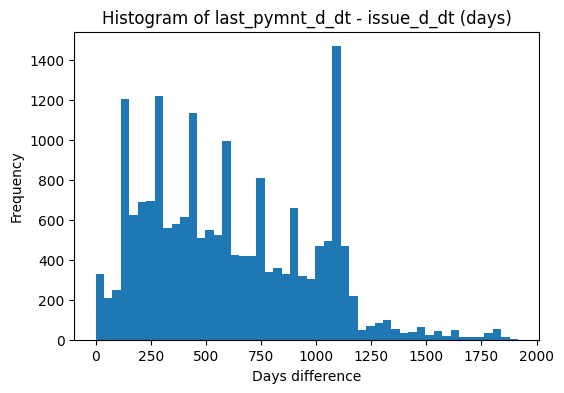

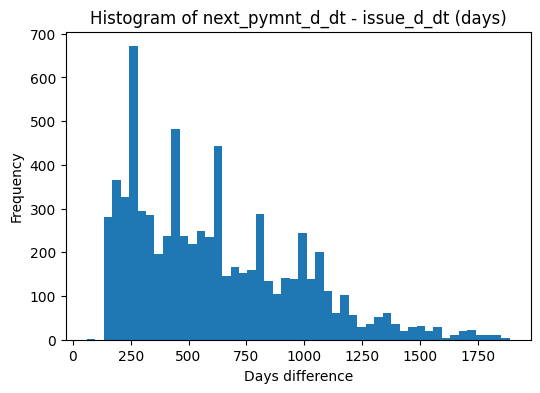

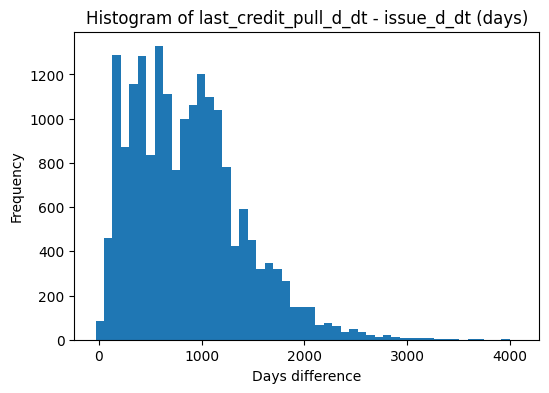

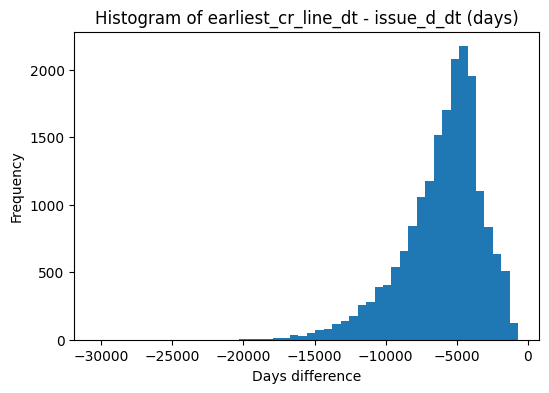

In [ ]:
# Pick the columns you want to compare against issue_d_dt
compare_cols = ["last_pymnt_d_dt", "next_pymnt_d_dt", "last_credit_pull_d_dt", "earliest_cr_line_dt"]

for col in compare_cols:
    if col in df.columns:
        # Compute difference in days (can change to months if you prefer)
        diff_days = (df[col] - df["issue_d_dt"]).dt.days

        # Drop missing values
        diff_days = diff_days.dropna()

        # Plot histogram
        plt.figure(figsize=(6,4))
        plt.hist(diff_days, bins=50)
        plt.title(f"Histogram of {col} - issue_d_dt (days)")
        plt.xlabel("Days difference")
        plt.ylabel("Frequency")
        plt.show()


### Investigate the spike in last_pymnt_d_dt - issue_d_dt

In [ ]:
# Count frequency of last_pymnt_d_dt values
counts = (
    df["last_pymnt_d_dt"]
    .value_counts(dropna=False)
    .sort_index()
)

counts_pct = (counts / len(df) * 100).round(2)

# Top 5 spike months
spike_months = counts_pct.sort_values(ascending=False).head(5)
print(spike_months)


last_pymnt_d_dt
2019-01-01    37.86
2018-07-01     1.88
2018-12-01     1.88
2018-03-01     1.87
2018-10-01     1.87
Name: count, dtype: float64


It looks like Jan-2019 is the timing of the last data in this data set...

## Analysis of Loan Amount vs. Funded vs. Invested

In [ ]:
def classify_relationship(row):
    a, f, i = row["loan_amnt"], row["funded_amnt"], row["funded_amnt_inv"]
    if pd.isna(a) or pd.isna(f) or pd.isna(i):
        return "missing"
    return f"loan={a}, funded={f}, inv={i}"

# Instead of returning exact numbers, we reduce to a pattern:
def classify_relationship(row):
    a, f, i = row["loan_amnt"], row["funded_amnt"], row["funded_amnt_inv"]
    if pd.isna(a) or pd.isna(f) or pd.isna(i):
        return "missing"
    if a == f == i:
        return "all equal"
    if a == f and f > i:
        return "loan=funded > investors"
    if a > f == i:
        return "loan > funded=investors"
    if a > f > i:
        return "loan > funded > investors"
    if a == f and i > f:  # shouldn’t happen but safe check
        return "investors > loan=funded"
    return "other pattern"

# Apply classification
cats = df.apply(classify_relationship, axis=1)

summary = (
    cats.value_counts()
        .to_frame("count")
        .assign(pct=lambda s: (s["count"] / len(df) * 100).round(2))
        .reset_index()
        .rename(columns={"index": "relationship"})
)

print(summary)


                relationship  count    pct
0                  all equal  17628  92.91
1    loan=funded > investors   1323   6.97
2  loan > funded > investors     18   0.09
3    loan > funded=investors      5   0.03


In [ ]:
# Select rows where loan_amnt is greater than funded_amnt
mask = df["loan_amnt"] > df["funded_amnt"]

# Or just peek at the first few
print(df[mask].head())



      loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment grade sub_grade                          emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status pymnt_plan                                               desc             purpose  \
267     35000.0      23950.0         23925.00   60 months     10.99       520.62     B        B3  Employment Development Department  10+ years       MORTGAGE    48712.44            Verified  Jul-2011   Fully Paid          n    Borrower added on 07/10/11 > I plan on using...      small_business   
534     22500.0      14025.0         14025.00   36 months      8.90       445.34     A        A5                 Henry Schein, Inc.  10+ years           RENT   185000.00        Not Verified  Jul-2012   Fully Paid          n    Borrower added on 06/14/12 > Thank you for c...  debt_consolidation   
2797     7500.0       3600.0          1969.97   36 months     11.34       118.44     C        C2          

# Target Engineering

In [ ]:
# Generate the target column, where the loan status is charged off
df['target'] = (df['loan_status'] == 'Charged Off').astype(int)

In [ ]:
pd.crosstab(df['issue_d_dt'], df['target']).head(30)

target       0  1
issue_d_dt       
2007-11-01   1  0
2007-12-01   1  0
2008-01-01   4  0
2008-02-01   3  0
2008-03-01   3  1
2008-04-01   2  0
2008-06-01   1  0
2008-07-01   1  0
2008-09-01   2  0
2008-10-01   2  0
2008-11-01   4  0
2008-12-01   1  1
2009-01-01   4  0
2009-02-01   2  1
2009-03-01   8  0
2009-04-01   4  0
2009-05-01   2  0
2009-06-01   7  0
2009-07-01   3  0
2009-08-01   4  0
2009-09-01   6  1
2009-10-01   8  1
2009-11-01   2  2
2009-12-01   4  0
2010-01-01   6  0
2010-02-01   5  0
2010-03-01   9  0
2010-04-01  10  0
2010-05-01   6  1
2010-06-01  10  1

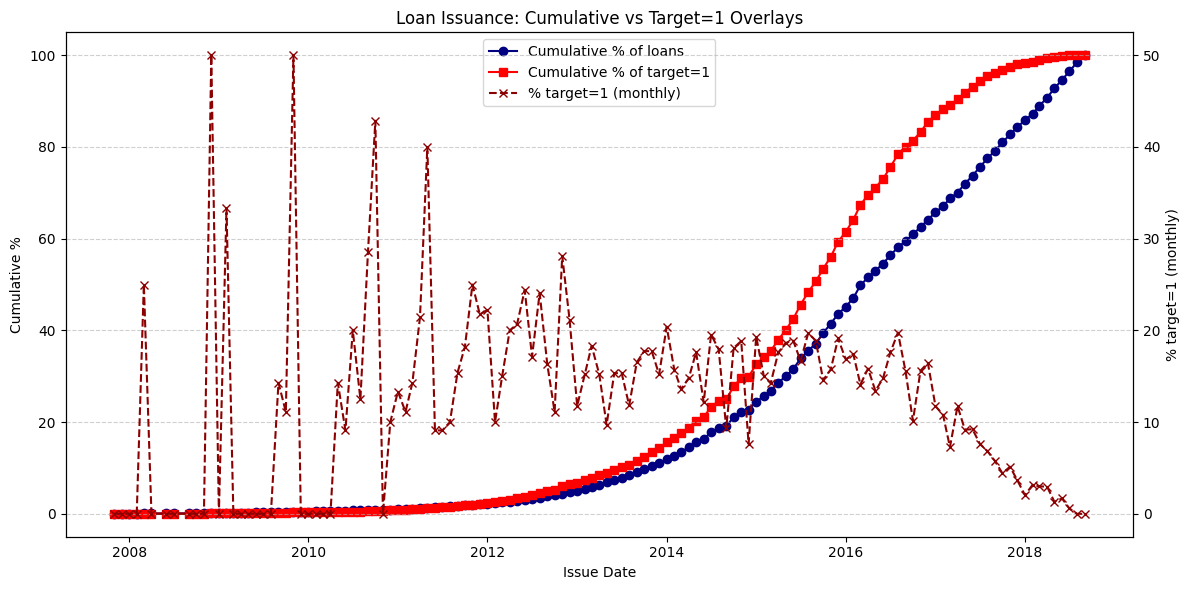

In [ ]:
# Aggregate by month
monthly = (
    df.groupby("issue_d_dt")
      .agg(
          total=("target", "size"),
          target1=("target", "sum")
      )
      .reset_index()
      .sort_values("issue_d_dt")
)

# Percentages
monthly["pct_target1"] = monthly["target1"] / monthly["total"] * 100
monthly["cum_pct_total"] = monthly["total"].cumsum() / monthly["total"].sum() * 100
monthly["cum_pct_target1"] = monthly["target1"].cumsum() / monthly["target1"].sum() * 100

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Lines for cumulative % of loans and target=1
ax1.plot(monthly["issue_d_dt"], monthly["cum_pct_total"], color="navy", marker="o", label="Cumulative % of loans")
ax1.plot(monthly["issue_d_dt"], monthly["cum_pct_target1"], color="red", marker="s", label="Cumulative % of target=1")

# Secondary axis for monthly % target=1
ax2 = ax1.twinx()
ax2.plot(monthly["issue_d_dt"], monthly["pct_target1"], color="darkred", marker="x", linestyle="--", label="% target=1 (monthly)")

# Labels and titles
ax1.set_title("Loan Issuance: Cumulative vs Target=1 Overlays")
ax1.set_xlabel("Issue Date")
ax1.set_ylabel("Cumulative %")
ax2.set_ylabel("% target=1 (monthly)")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")

plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


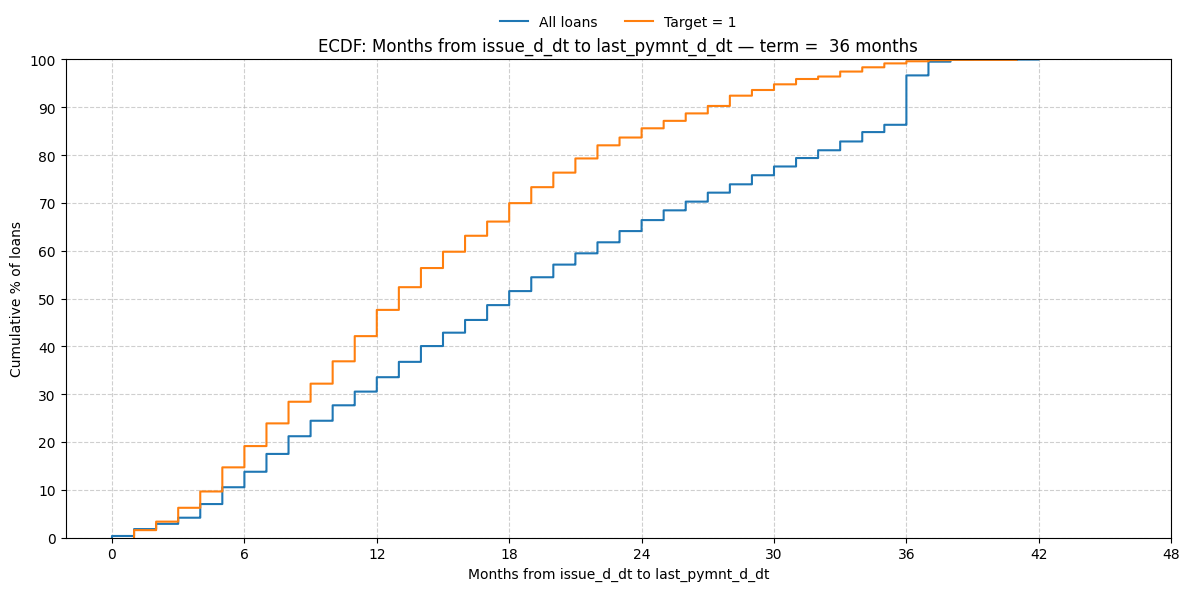

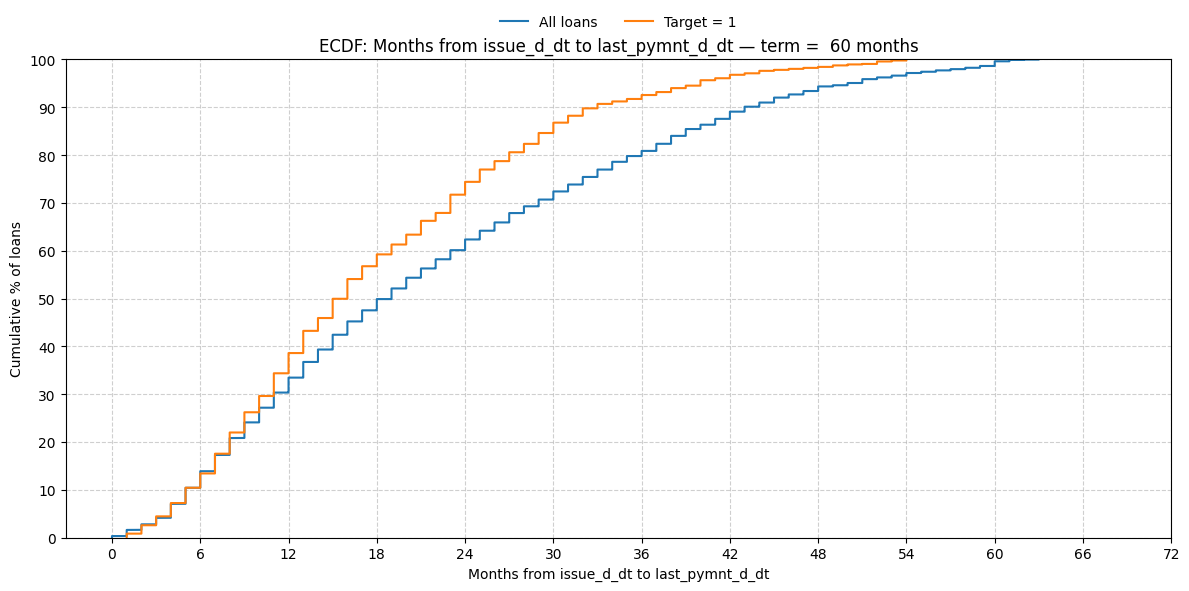

In [ ]:
# --- Helpers
def ecdf(series):
    s = np.asarray(series.dropna())
    if s.size == 0:
        return np.array([]), np.array([])
    s = np.sort(s)
    y = np.arange(1, s.size + 1) / s.size * 100.0
    return s, y

def month_diff(later, earlier):
    # integer months via period ordinals avoids MonthEnd offset issues
    return later.dt.to_period("M").astype(int) - earlier.dt.to_period("M").astype(int)

# --- Ensure required columns exist
required = {"issue_d_dt", "last_pymnt_d_dt", "term", "target"}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# --- Iterate each term (e.g., '36 months', '60 months', etc.)
for term_val in sorted(df["term"].dropna().unique(), key=lambda s: str(s)):
    sub = df[df["term"] == term_val].copy()

    # Filter rows that have both dates
    mask_all = sub["last_pymnt_d_dt"].notna() & sub["issue_d_dt"].notna()
    if not mask_all.any():
        print(f"[skip] term={term_val}: no rows with both dates.")
        continue

    # Month diffs
    all_months = month_diff(sub.loc[mask_all, "last_pymnt_d_dt"], sub.loc[mask_all, "issue_d_dt"])

    mask_t1 = mask_all & (sub["target"] == 1)
    t1_months = month_diff(sub.loc[mask_t1, "last_pymnt_d_dt"], sub.loc[mask_t1, "issue_d_dt"])

    # Build ECDFs
    x_all, y_all = ecdf(all_months)
    x_t1,  y_t1  = ecdf(t1_months)

    # Skip if nothing to plot
    if x_all.size == 0 and x_t1.size == 0:
        print(f"[skip] term={term_val}: no valid diffs.")
        continue

    # Plot one figure per term
    fig, ax = plt.subplots(figsize=(12,6))

    if x_all.size:
        ax.step(x_all, y_all, where="post", label="All loans")
    if x_t1.size:
        ax.step(x_t1,  y_t1,  where="post", label="Target = 1")

    ax.set_title(f"ECDF: Months from issue_d_dt to last_pymnt_d_dt — term = {term_val}")
    ax.set_xlabel("Months from issue_d_dt to last_pymnt_d_dt")
    ax.set_ylabel("Cumulative % of loans")
    ax.set_yticks(np.linspace(0, 100, 11))
    ax.set_ylim(0, 100)

    # 6-month x-axis ticks
    # Use current x-limits after plotting to derive a sensible max
    xmin, xmax = ax.get_xlim()
    # ensure start at 0 for readability
    xmin = 0 if np.isfinite(xmin) else 0
    xmax = max(6, xmax) if np.isfinite(xmax) else 6
    xticks = np.arange(0, xmax + 6, 6)
    ax.set_xticks(xticks)

    # Legend at top center
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=2, frameon=False)

    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.show()

# Feature Engineering Earliest credit line, bal_to_inc, and installment_to_inc

In [ ]:
# Engineer a new feature for earliest_cr_line
df["earliest_cr_line_years"] = (df["issue_d_dt"].dt.year - df["earliest_cr_line_dt"].dt.year) + (df["issue_d_dt"].dt.month - df["earliest_cr_line_dt"].dt.month) / 12.0
# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(df["earliest_cr_line_years"], bins=10)
plt.title(f"Histogram of earliest_cr_line_years")
plt.xlabel("Years")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Feature idea: installment / annual_inc?  ... ability to pay?
#feature showing average balance to income ratio
df['bal_to_inc'] = df['tot_cur_bal'] / df['annual_inc']

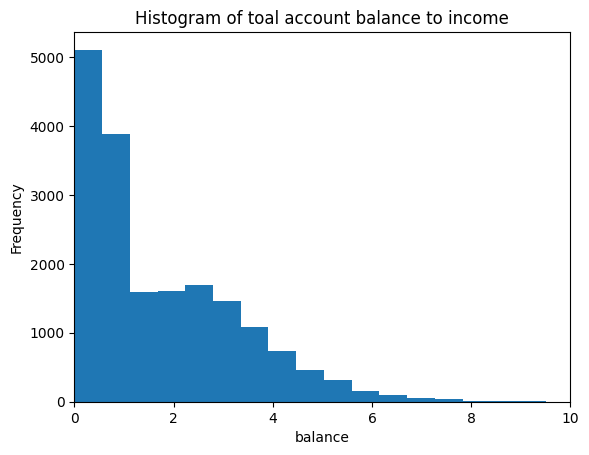

In [ ]:
plt.hist(df["bal_to_inc"], bins=20)
plt.title(f"Histogram of toal account balance to income")
plt.xlabel("balance")
plt.xlim(0,10)
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Feature idea: installment / annual_inc?  ... ability to pay
df['installment_to_inc'] = df['installment'] / df['annual_inc']

In [ ]:
plt.hist(df["installment_to_inc"], bins=20)
plt.title(f"Histogram of installment to income")
plt.xlabel("installment")
plt.xlim(0,.03
         )
plt.ylabel("Frequency")
plt.show()

In [ ]:
#feature indicating if the borrower was never delinquent  or had a public record
df['never_delinquent'] = (df['mths_since_last_delinq'].isnull()) & (df['mths_since_last_record'].isnull())
print(df['never_delinquent'].value_counts())

never_delinquent
False    11004
True      7970
Name: count, dtype: int64


## Investigating relationship of Target variable and Issuance Date to determine where to Trim the Set


<Axes: xlabel='issue_d_dt'>

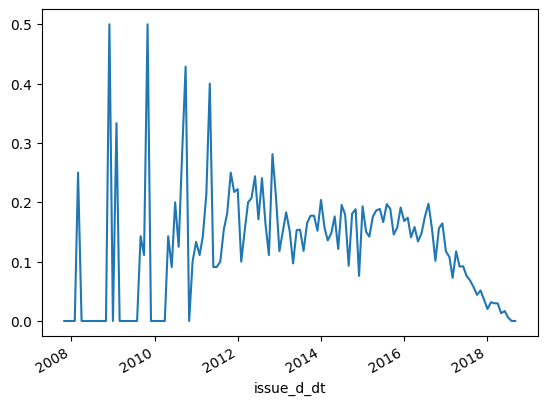

In [ ]:
#plotting target ratio by issue_d
df.groupby('issue_d_dt')['target'].mean().plot()

In [ ]:
#filtering the dataset for loans with issue_d_date before January 1 2017, because there is a clear drop off in the charge off rate past 2017, likely because we aren't seeing those loans come close to maturity
df = df[df['issue_d_dt'] < '2017-01-01']

#Exluding Post Origination Decision Features

In [ ]:
# Any columns created above (for temporary use)
temp_use_columns = ["issue_d_dt", "last_pymnt_d_dt", "next_pymnt_d_dt", "last_credit_pull_d_dt", "earliest_cr_line_dt"]
# Remove columns that exist in the DataFrame
cols_to_drop = [col for col in temp_use_columns if col in df.columns]
df = df.drop(columns=cols_to_drop)

# Loan info
loan_info_columns = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "issue_d"]
cols_to_drop = [col for col in loan_info_columns if col in df.columns]
df = df.drop(columns=cols_to_drop)

# Post-loan info
post_loan_info = ["loan_status", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv",
"total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
"collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt",
"next_pymnt_d", "last_credit_pull_d"]
cols_to_drop = [col for col in post_loan_info if col in df.columns]
df = df.drop(columns=cols_to_drop)

In [ ]:
#dropping grade,sub_grade, initial list status, and term features due to their potential for leaking LCs risk determination to the model
df = df.drop(columns=['grade', 'sub_grade'])

In [ ]:
df = df.drop(columns=['initial_list_status', 'term'])

In [ ]:
#dropping emp_title due to high cardinality
df = df.drop(columns=['emp_title'])

## Adjusting emp_length

In [ ]:
#checking emp_length values
df['emp_length'].value_counts()


emp_length
10+ years    4149
2 years      1107
3 years       933
< 1 year      924
1 year        781
5 years       767
4 years       703
8 years       604
6 years       542
7 years       496
9 years       471
Name: count, dtype: int64

In [ ]:
#converting empl_length to numeric scale
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length_num'] = df['emp_length'].map(emp_length_map)


In [ ]:
df = df.drop(columns=['emp_length'])

In [ ]:
#dropping fico range high, as its correlated to fico range low
df = df.drop(columns = ['fico_range_high'])

In [ ]:
print(df['home_ownership'].value_counts())

home_ownership
MORTGAGE    6003
RENT        4818
OWN         1350
ANY            2
OTHER          1
Name: count, dtype: int64


In [ ]:
#dropping values of home ownership for 'any' and 'other'
df = df[df['home_ownership'] != 'ANY']
df = df[df['home_ownership'] != 'OTHER']

In [ ]:
#checking the value counts of verification status
df['verification_status'].value_counts()

verification_status
Source Verified    4727
Verified           3891
Not Verified       3553
Name: count, dtype: int64

In [ ]:
print(df['pymnt_plan'].value_counts())

pymnt_plan
n    12168
y        3
Name: count, dtype: int64


## Feature exploration and Dropping of un-needed features

In [ ]:
#dropping paymnt_plan variable
df = df.drop(columns=['pymnt_plan'])

In [ ]:
print(df['purpose'].value_counts())

purpose
debt_consolidation    7160
credit_card           2708
home_improvement       731
other                  693
major_purchase         257
small_business         143
medical                131
car                    125
moving                  72
vacation                60
house                   56
wedding                 18
renewable_energy        11
educational              6
Name: count, dtype: int64


In [ ]:
# dropping zip code variable
df = df.drop(columns=['zip_code'])

In [ ]:
#dropping 'addr_state' variable
df = df.drop(columns=['addr_state'])

In [ ]:
print(df['inq_fi'].value_counts())

inq_fi
0.0     2172
1.0      941
2.0      498
3.0      237
4.0      116
5.0       72
6.0       34
7.0       15
8.0        8
9.0        7
10.0       5
16.0       1
13.0       1
12.0       1
11.0       1
14.0       1
Name: count, dtype: int64


## Null Treatment

In [ ]:
#converting nulls for df['inq_fi] to 0 and adding a flag
df['inq_fi_missing'] = df['inq_fi'].isna().astype(int)
df['inq_fi'] = df['inq_fi'].fillna(0)

In [ ]:
df['total_cu_tl_missing'] = df['total_cu_tl'].isna().astype(int)
df['total_cu_tl'] = df['total_cu_tl'].fillna(0)

In [ ]:
df['inq_last_12m_missing'] = df['inq_last_12m'].isna().astype(int)
df['inq_last_12m'] = df['inq_last_12m'].fillna(0)

In [ ]:
#investigating null counts per feature
df.isnull().sum()

home_ownership                        0
annual_inc                            0
verification_status                   0
desc                              10992
purpose                               0
title                               215
dti                                   0
delinq_2yrs                           0
earliest_cr_line                      0
fico_range_low                        0
inq_last_6mths                        0
mths_since_last_delinq             6105
mths_since_last_record            10085
open_acc                              0
pub_rec                               0
revol_bal                             0
revol_util                            8
total_acc                             0
last_fico_range_high                  0
last_fico_range_low                   0
collections_12_mths_ex_med            0
mths_since_last_major_derog        9049
acc_now_delinq                        0
tot_coll_amt                        660
tot_cur_bal                         660
open_acc_6m                        8061
open_act_il                        8061
open_il_12m                        8061
open_il_24m                        8061
mths_since_rcnt_il                 8184
total_bal_il                       8061
il_util                            8637
open_rv_12m                        8061
open_rv_24m                        8061
max_bal_bc                         8061
all_util                           8062
total_rev_hi_lim                    660
inq_fi                                0
total_cu_tl                           0
inq_last_12m                          0
acc_open_past_24mths                457
avg_cur_bal                         660
bc_open_to_buy                      572
bc_util                             582
chargeoff_within_12_mths              0
delinq_amnt                           0
mo_sin_old_il_acct                  979
mo_sin_old_rev_tl_op                660
mo_sin_rcnt_rev_tl_op               660
mo_sin_rcnt_tl                      660
mort_acc                            457
mths_since_recent_bc                561
mths_since_recent_bc_dlq           9298
mths_since_recent_inq              1619
mths_since_recent_revol_delinq     8076
num_accts_ever_120_pd               660
num_actv_bc_tl                      660
num_actv_rev_tl                     660
num_bc_sats                         553
num_bc_tl                           660
num_il_tl                           660
num_op_rev_tl                       660
num_rev_accts                       660
num_rev_tl_bal_gt_0                 660
num_sats                            553
num_tl_120dpd_2m                   1102
num_tl_30dpd                        660
num_tl_90g_dpd_24m                  660
num_tl_op_past_12m                  660
pct_tl_nvr_dlq                      660
percent_bc_gt_75                    574
pub_rec_bankruptcies                 11
tax_liens                             0
tot_hi_cred_lim                     660
total_bal_ex_mort                   457
total_bc_limit                      457
total_il_high_credit_limit          660
target                                0
earliest_cr_line_years                0
bal_to_inc                          660
installment_to_inc                    0
never_delinquent                      0
emp_length_num                      697
inq_fi_missing                        0
total_cu_tl_missing                   0
inq_last_12m_missing                  0
dtype: int64

In [ ]:
missing_credit_field_cols = ['tot_coll_amt', 'tot_cur_bal','mort_acc', 'total_rev_hi_lim', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m','num_tl_op_past_12m', 'percent_bc_gt_75', 'pub_rec_bankruptcies','tot_hi_cred_lim', 'total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit', 'bal_to_inc', 'emp_length_num']
for col in missing_credit_field_cols:
    df[col + '_missing'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(0)

In [ ]:
#Dropping rows with null value for num_il_tl
df = df.dropna(subset=['num_il_tl'])

In [ ]:
print(df['pct_tl_nvr_dlq'].value_counts())

pct_tl_nvr_dlq
100.0    5632
95.0      196
90.0      164
96.0      138
92.9      121
93.3      118
88.9      115
85.7      115
92.3      115
90.9      115
91.7      113
87.5      108
80.0      108
94.1      107
94.4      107
95.2      106
95.5      100
83.3       96
97.0       96
93.7       95
95.7       88
94.7       88
92.0       81
96.2       73
95.8       72
94.0       72
97.1       66
96.3       64
88.2       63
93.0       62
96.6       60
75.0       59
87.0       58
96.4       54
96.8       53
85.0       52
97.4       50
88.0       49
89.5       49
86.7       47
96.7       47
84.6       47
96.9       47
91.3       45
90.5       45
93.1       40
98.0       39
88.5       37
66.7       37
93.5       36
77.8       35
91.0       35
92.6       35
81.0       34
81.8       34
86.4       34
81.2       33
82.4       32
97.6       32
89.7       32
84.2       31
97.3       30
97.7       30
97.8       29
84.0       28
86.0       28
94.6       26
94.3       26
78.6       25
97.2       24
78.9 

In [ ]:
df['pct_tl_nvr_dlq_missing'] = df['pct_tl_nvr_dlq'].isna().astype(int)
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'].fillna(100.0)

In [ ]:
df.isnull().sum()

home_ownership                            0
annual_inc                                0
verification_status                       0
desc                                  10773
purpose                                   0
title                                   215
dti                                       0
delinq_2yrs                               0
earliest_cr_line                          0
fico_range_low                            0
inq_last_6mths                            0
mths_since_last_delinq                 5677
mths_since_last_record                 9469
open_acc                                  0
pub_rec                                   0
revol_bal                                 0
revol_util                                8
total_acc                                 0
last_fico_range_high                      0
last_fico_range_low                       0
collections_12_mths_ex_med                0
mths_since_last_major_derog            8389
acc_now_delinq                            0
tot_coll_amt                              0
tot_cur_bal                               0
open_acc_6m                            7401
open_act_il                            7401
open_il_12m                            7401
open_il_24m                            7401
mths_since_rcnt_il                     7524
total_bal_il                           7401
il_util                                7977
open_rv_12m                            7401
open_rv_24m                            7401
max_bal_bc                             7401
all_util                               7402
total_rev_hi_lim                          0
inq_fi                                    0
total_cu_tl                               0
inq_last_12m                              0
acc_open_past_24mths                      0
avg_cur_bal                               0
bc_open_to_buy                          112
bc_util                                 122
chargeoff_within_12_mths                  0
delinq_amnt                               0
mo_sin_old_il_acct                      319
mo_sin_old_rev_tl_op                      0
mo_sin_rcnt_rev_tl_op                     0
mo_sin_rcnt_tl                            0
mort_acc                                  0
mths_since_recent_bc                    101
mths_since_recent_bc_dlq               8638
mths_since_recent_inq                  1139
mths_since_recent_revol_delinq         7471
num_accts_ever_120_pd                     0
num_actv_bc_tl                            0
num_actv_rev_tl                           0
num_bc_sats                               0
num_bc_tl                                 0
num_il_tl                                 0
num_op_rev_tl                             0
num_rev_accts                             0
num_rev_tl_bal_gt_0                       0
num_sats                                  0
num_tl_120dpd_2m                          0
num_tl_30dpd                              0
num_tl_90g_dpd_24m                        0
num_tl_op_past_12m                        0
pct_tl_nvr_dlq                            0
percent_bc_gt_75                          0
pub_rec_bankruptcies                      0
tax_liens                                 0
tot_hi_cred_lim                           0
total_bal_ex_mort                         0
total_bc_limit                            0
total_il_high_credit_limit                0
target                                    0
earliest_cr_line_years                    0
bal_to_inc                                0
installment_to_inc                        0
never_delinquent                          0
emp_length_num                            0
inq_fi_missing                            0
total_cu_tl_missing                       0
inq_last_12m_missing                      0
tot_coll_amt_missing                      0
tot_cur_bal_missing                       0
mort_acc_missing                          0
total_rev_hi_lim_missing                  0
num_actv_bc_tl_missing                  

In [ ]:
print(df['open_rv_24m'].value_counts())

open_rv_24m
1.0     815
2.0     754
3.0     617
0.0     575
4.0     434
5.0     314
6.0     222
7.0     142
8.0      88
9.0      47
10.0     33
11.0     22
12.0     11
13.0     11
16.0      6
15.0      6
14.0      6
19.0      2
17.0      2
33.0      1
24.0      1
22.0      1
Name: count, dtype: int64


In [ ]:
more_missing_cols = [
    "open_acc_6m",
    "open_act_il",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "il_util",
    "open_rv_12m",
    "open_rv_24m",
    "max_bal_bc",
    "all_util",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_util",
    'mort_acc',
    'num_accts_ever_120_pd'
]

# Create a binary missing flag for each column
for c in more_missing_cols:
    df[f"{c}_missing"] = df[c].isna().astype(int)


df[more_missing_cols] = df[more_missing_cols].fillna(0)

In [ ]:
df.isnull().sum()

home_ownership                            0
annual_inc                                0
verification_status                       0
desc                                  10773
purpose                                   0
title                                   215
dti                                       0
delinq_2yrs                               0
earliest_cr_line                          0
fico_range_low                            0
inq_last_6mths                            0
mths_since_last_delinq                 5677
mths_since_last_record                 9469
open_acc                                  0
pub_rec                                   0
revol_bal                                 0
revol_util                                8
total_acc                                 0
last_fico_range_high                      0
last_fico_range_low                       0
collections_12_mths_ex_med                0
mths_since_last_major_derog            8389
acc_now_delinq                            0
tot_coll_amt                              0
tot_cur_bal                               0
open_acc_6m                               0
open_act_il                               0
open_il_12m                               0
open_il_24m                               0
mths_since_rcnt_il                        0
total_bal_il                              0
il_util                                   0
open_rv_12m                               0
open_rv_24m                               0
max_bal_bc                                0
all_util                                  0
total_rev_hi_lim                          0
inq_fi                                    0
total_cu_tl                               0
inq_last_12m                              0
acc_open_past_24mths                      0
avg_cur_bal                               0
bc_open_to_buy                          112
bc_util                                   0
chargeoff_within_12_mths                  0
delinq_amnt                               0
mo_sin_old_il_acct                      319
mo_sin_old_rev_tl_op                      0
mo_sin_rcnt_rev_tl_op                     0
mo_sin_rcnt_tl                            0
mort_acc                                  0
mths_since_recent_bc                    101
mths_since_recent_bc_dlq               8638
mths_since_recent_inq                  1139
mths_since_recent_revol_delinq         7471
num_accts_ever_120_pd                     0
num_actv_bc_tl                            0
num_actv_rev_tl                           0
num_bc_sats                               0
num_bc_tl                                 0
num_il_tl                                 0
num_op_rev_tl                             0
num_rev_accts                             0
num_rev_tl_bal_gt_0                       0
num_sats                                  0
num_tl_120dpd_2m                          0
num_tl_30dpd                              0
num_tl_90g_dpd_24m                        0
num_tl_op_past_12m                        0
pct_tl_nvr_dlq                            0
percent_bc_gt_75                          0
pub_rec_bankruptcies                      0
tax_liens                                 0
tot_hi_cred_lim                           0
total_bal_ex_mort                         0
total_bc_limit                            0
total_il_high_credit_limit                0
target                                    0
earliest_cr_line_years                    0
bal_to_inc                                0
installment_to_inc                        0
never_delinquent                          0
emp_length_num                            0
inq_fi_missing                            0
total_cu_tl_missing                       0
inq_last_12m_missing                      0
tot_coll_amt_missing                      0
tot_cur_bal_missing                       0
mort_acc_missing                          0
total_rev_hi_lim_missing                  0
num_actv_bc_tl_missing                  

In [ ]:
#dropping desc because it is not predictive, just a text description of the loan
df = df.drop(columns=['desc'])


In [ ]:
df = df.drop(columns = ['title'])

In [ ]:
print(df.head())

  home_ownership  annual_inc verification_status             purpose    dti  delinq_2yrs earliest_cr_line  fico_range_low  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  total_acc  last_fico_range_high  last_fico_range_low  \
1           RENT     65878.0            Verified  debt_consolidation   7.91          0.0         Jun-2000           730.0             3.0                    25.0                     NaN       9.0      0.0     3671.0        17.9       17.0                 734.0                730.0   
3       MORTGAGE     64000.0        Not Verified  debt_consolidation  14.34          0.0         Jul-2000           740.0             0.0                     NaN                     NaN       8.0      0.0    18485.0        65.8       16.0                 564.0                560.0   
4           RENT     73000.0            Verified  debt_consolidation  21.17          0.0         Dec-1994           690.0             0.0        

In [ ]:
df = df.drop(columns = ['earliest_cr_line'])

###Evaluating the correlation of features to trim the dataframe to no more than 10 features for parsimonious modeling

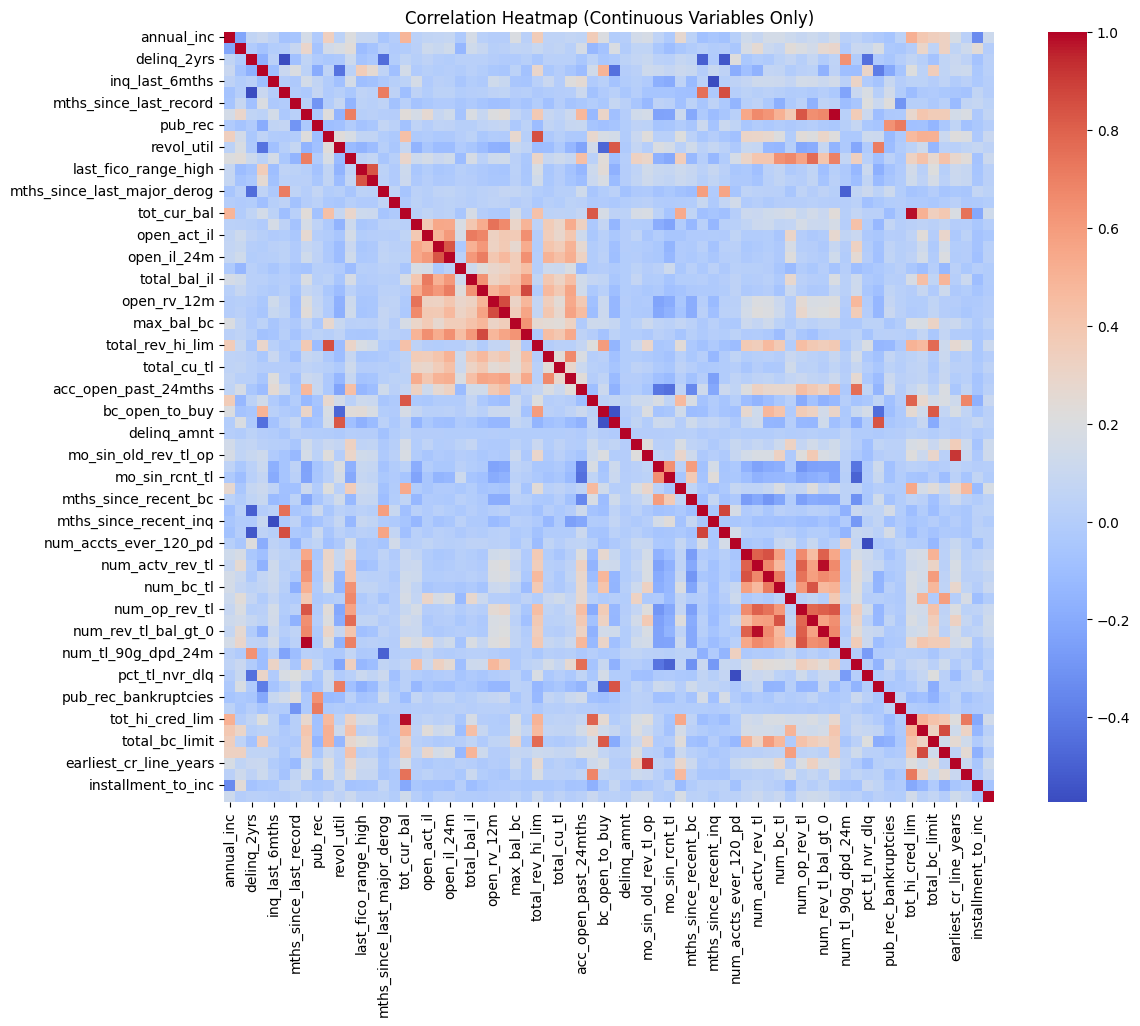

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Narrow down continuous variables
continuous_df = df.select_dtypes(include=['float64', 'int64']).copy()

# 2. Drop likely categorical integer columns (optional)
to_drop = []

# Drop obvious identifiers if present
id_like = ['id', 'member_id', 'loan_id']
for col in id_like:
    if col in continuous_df.columns:
        to_drop.append(col)

# Drop columns with too few unique values (e.g., 0/1, enums)
for col in continuous_df.columns:
    if continuous_df[col].nunique() <= 5:
        to_drop.append(col)

continuous_df = continuous_df.drop(columns=set(to_drop), errors='ignore')

# 3. Compute correlation matrix
corr = continuous_df.corr()

# 4. Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
plt.title("Correlation Heatmap (Continuous Variables Only)")
plt.show()


In [ ]:
import numpy as np

# 1. Select numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()

# 2. Remove ID-like columns
id_like = ['id', 'member_id', 'loan_id']
for col in id_like:
    if col in numeric_df.columns:
        numeric_df.drop(columns=col, inplace=True)

# 3. Remove integer columns with very few distinct values (likely categorical)
for col in numeric_df.columns:
    if numeric_df[col].dtype in ['int64'] and numeric_df[col].nunique() <= 5:
        numeric_df.drop(columns=col, inplace=True)

# 4. Compute correlation matrix
corr = numeric_df.corr().abs()

# 5. Flatten, remove self-correlations, sort
corr_sorted = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))
        .unstack()
        .dropna()
        .sort_values(ascending=False)
)

# 6. Print
print(corr_sorted)


num_sats                        open_acc                          0.998839
open_acc                        num_sats                          0.998839
tot_cur_bal                     tot_hi_cred_lim                   0.986593
tot_hi_cred_lim                 tot_cur_bal                       0.986593
num_actv_rev_tl                 num_rev_tl_bal_gt_0               0.984980
num_rev_tl_bal_gt_0             num_actv_rev_tl                   0.984980
mo_sin_old_rev_tl_op            earliest_cr_line_years            0.918871
earliest_cr_line_years          mo_sin_old_rev_tl_op              0.918871
mths_since_recent_bc_dlq        mths_since_recent_revol_delinq    0.878203
mths_since_recent_revol_delinq  mths_since_recent_bc_dlq          0.878203
all_util                        il_util                           0.865073
il_util                         all_util                          0.865073
open_rv_12m                     open_rv_24m                       0.863249
open_rv_24m              

In [ ]:
#creating new dataframe exlcuding one feature from each pair that had a correlation of over 0.80
pars_df = df.drop(columns=['num_sats', 'tot_hi_cred_lim', 'num_rev_tl_bal_gt_0', 'mo_sin_old_rev_tl_op', 'mths_since_recent_revol_delinq', 'il_util', 'open_rv_12m', 'total_il_high_credit_limit', 'mths_since_recent_revol_delinq', 'total_rev_hi_lim', 'num_actv_bc_tl', 'percent_bc_gt_75', 'num_rev_accts', 'last_fico_range_low', 'num_op_rev_tl', 'open_il_24m', 'revol_util', 'tot_cur_bal', 'bc_open_to_buy', 'num_rev_tl_bal_gt_0', 'num_actv_rev_tl', 'num_actv_bc_tl', 'num_rev_tl_bal_gt_0'])

In [ ]:
#dropping missing variable flagsdf = df.drop(columns=[col for col in df.columns if col.endswith('missing')])
pars_df = pars_df.drop(columns=[col for col in df.columns if col.endswith('missing')])


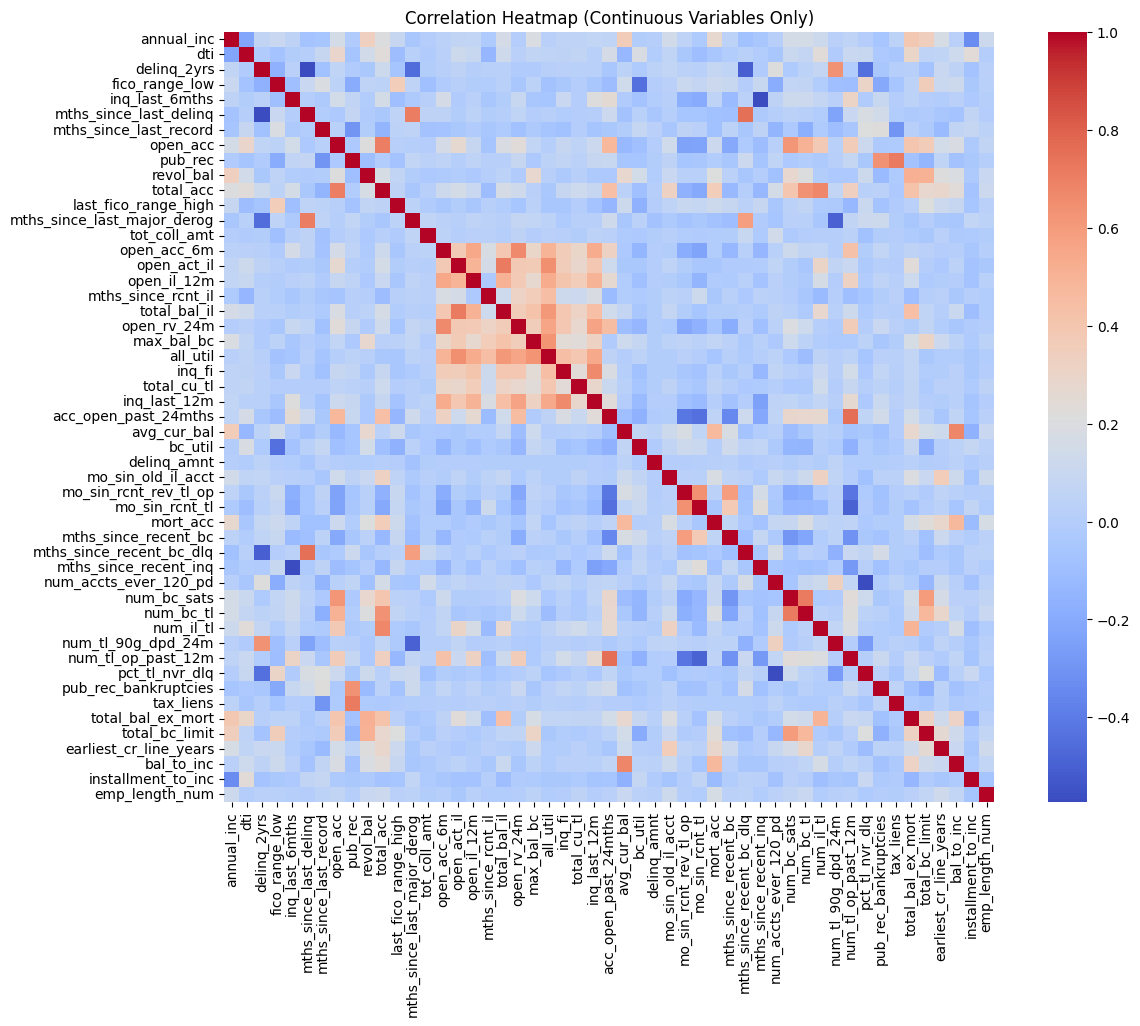

In [ ]:
#re-visualizing correlated variables
# 1. Narrow down continuous variables
continuous_df = pars_df.select_dtypes(include=['float64', 'int64']).copy()

# 2. Drop likely categorical integer columns (optional)
to_drop = []

# Drop obvious identifiers if present
id_like = ['id', 'member_id', 'loan_id']
for col in id_like:
    if col in continuous_df.columns:
        to_drop.append(col)

# Drop columns with too few unique values (e.g., 0/1, enums)
for col in continuous_df.columns:
    if continuous_df[col].nunique() <= 5:
        to_drop.append(col)

continuous_df = continuous_df.drop(columns=set(to_drop), errors='ignore')

# 3. Compute correlation matrix
corr = continuous_df.corr()

# 4. Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
plt.title("Correlation Heatmap (Continuous Variables Only)")
plt.show()

In [ ]:
# 1. Select numeric columns
numeric_df = pars_df.select_dtypes(include=['float64', 'int64']).copy()

# 2. Remove ID-like columns
id_like = ['id', 'member_id', 'loan_id']
for col in id_like:
    if col in numeric_df.columns:
        numeric_df.drop(columns=col, inplace=True)

# 3. Remove integer columns with very few distinct values (likely categorical)
for col in numeric_df.columns:
    if numeric_df[col].dtype in ['int64'] and numeric_df[col].nunique() <= 5:
        numeric_df.drop(columns=col, inplace=True)

# 4. Compute correlation matrix
corr = numeric_df.corr().abs()

# 5. Flatten, remove self-correlations, sort
corr_sorted = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))
        .unstack()
        .dropna()
        .sort_values(ascending=False)
)

# 6. Print
print(corr_sorted)

acc_now_delinq               num_tl_30dpd                   0.791244
num_tl_30dpd                 acc_now_delinq                 0.791244
acc_open_past_24mths         num_tl_op_past_12m             0.757493
num_tl_op_past_12m           acc_open_past_24mths           0.757493
mths_since_last_delinq       mths_since_recent_bc_dlq       0.753511
mths_since_recent_bc_dlq     mths_since_last_delinq         0.753511
num_bc_sats                  num_bc_tl                      0.716580
num_bc_tl                    num_bc_sats                    0.716580
total_bal_il                 open_act_il                    0.715573
open_act_il                  total_bal_il                   0.715573
tax_liens                    pub_rec                        0.715228
pub_rec                      tax_liens                      0.715228
mths_since_last_major_derog  mths_since_last_delinq         0.711086
mths_since_last_delinq       mths_since_last_major_derog    0.711086
total_acc                    open_

In [ ]:
#dropping variables with greater than 0.75 correl
pars_df = pars_df.drop(columns=['num_tl_30dpd', 'num_tl_op_past_12m', 'mths_since_recent_bc_dlq'])

## Creating preliminary XGBoost model to extract feature importances, with the purpose of using those features to build a more parsimonious model

In [ ]:
#copying df
df_pars_xgb = pars_df.copy()
print(df_pars_xgb.shape)

(11511, 58)


In [ ]:
cat_cols = df_pars_xgb.select_dtypes(include=['object', 'category']).columns
print(cat_cols.tolist())

['home_ownership', 'verification_status', 'purpose']


In [ ]:
#no need to one-hot encode, as XBG has a paramter which enables this to happen automatically

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


In [ ]:
cat_cols = df_pars_xgb.select_dtypes(include="object").columns
df_pars_xgb[cat_cols] = df_pars_xgb[cat_cols].astype("category")

In [ ]:
# Split X / y
y = df_pars_xgb["target"]
X = df_pars_xgb.drop(columns=["target"])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split



# 1) Train / test split and model fit

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    enable_categorical=True,   # <<<<<< THIS IS THE KEY
    n_jobs=-1
)

xgb_clf.fit(X_train, y_train)

# -------------------------------------------------------------------
# 1) Print evaluation metrics
# -------------------------------------------------------------------
y_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("=== Evaluation Metrics (XGBoost) ===")
print(f"Accuracy     : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))


=== Evaluation Metrics (XGBoost) ===
Accuracy     : 0.8914
ROC AUC      : 0.9391

Classification report:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1925
           1       0.67      0.67      0.67       378

    accuracy                           0.89      2303
   macro avg       0.80      0.80      0.80      2303
weighted avg       0.89      0.89      0.89      2303

Confusion matrix:

[[1799  126]
 [ 124  254]]



Computing permutation importances...

Top 30 features by permutation importance (mean Δ ROC AUC):
last_fico_range_high           0.420058
installment_to_inc             0.005242
total_bc_limit                 0.002465
total_acc                      0.001850
mo_sin_old_il_acct             0.001586
revol_bal                      0.001088
mths_since_last_major_derog    0.001003
pct_tl_nvr_dlq                 0.000790
mths_since_last_record         0.000777
fico_range_low                 0.000773
earliest_cr_line_years         0.000628
total_bal_ex_mort              0.000598
verification_status            0.000589
open_acc                       0.000566
num_bc_tl                      0.000565
avg_cur_bal                    0.000562
mo_sin_rcnt_rev_tl_op          0.000519
bc_util                        0.000517
bal_to_inc                     0.000270
num_il_tl                      0.000251
mo_sin_rcnt_tl                 0.000212
open_act_il                    0.000211
mths_since_recent_bc 

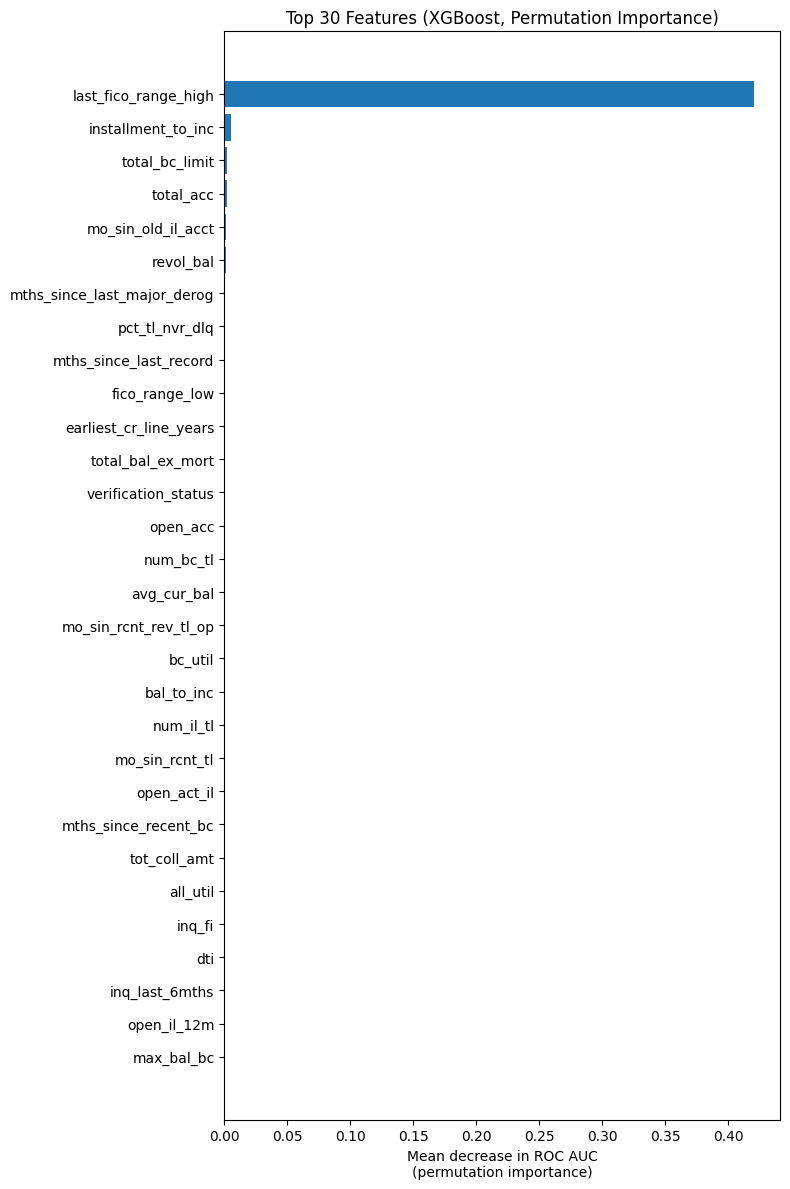

In [ ]:
# 2) Permutation feature importance
# -------------------------------------------------------------------
print("\nComputing permutation importances...")

perm_result = permutation_importance(
    xgb_clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

perm_importances = pd.Series(
    perm_result.importances_mean,
    index=X.columns
).sort_values(ascending=False)

print("\nTop 30 features by permutation importance (mean Δ ROC AUC):")
print(perm_importances.head(30))

# -------------------------------------------------------------------
# 3) Plot top 30 features
# -------------------------------------------------------------------
top_n = 30
top_feats = perm_importances.head(top_n).iloc[::-1]  # reverse for barh

plt.figure(figsize=(8, 12))
plt.barh(top_feats.index, top_feats.values)
plt.xlabel("Mean decrease in ROC AUC\n(permutation importance)")
plt.title(f"Top {top_n} Features (XGBoost, Permutation Importance)")
plt.tight_layout()
plt.show()

Top features by importance:
last_fico_range_high           0.238194
fico_range_low                 0.023952
collections_12_mths_ex_med     0.023661
verification_status            0.022621
installment_to_inc             0.020022
max_bal_bc                     0.019903
pct_tl_nvr_dlq                 0.018575
pub_rec                        0.018270
inq_fi                         0.017449
total_bal_ex_mort              0.017312
purpose                        0.017081
total_cu_tl                    0.016835
num_bc_tl                      0.016332
dti                            0.016323
all_util                       0.016196
mths_since_rcnt_il             0.015929
total_acc                      0.015779
open_acc                       0.015632
revol_bal                      0.015529
mths_since_last_major_derog    0.015336
annual_inc                     0.015287
mo_sin_old_il_acct             0.015257
total_bc_limit                 0.015197
mths_since_recent_bc           0.014906
bal_to_inc  

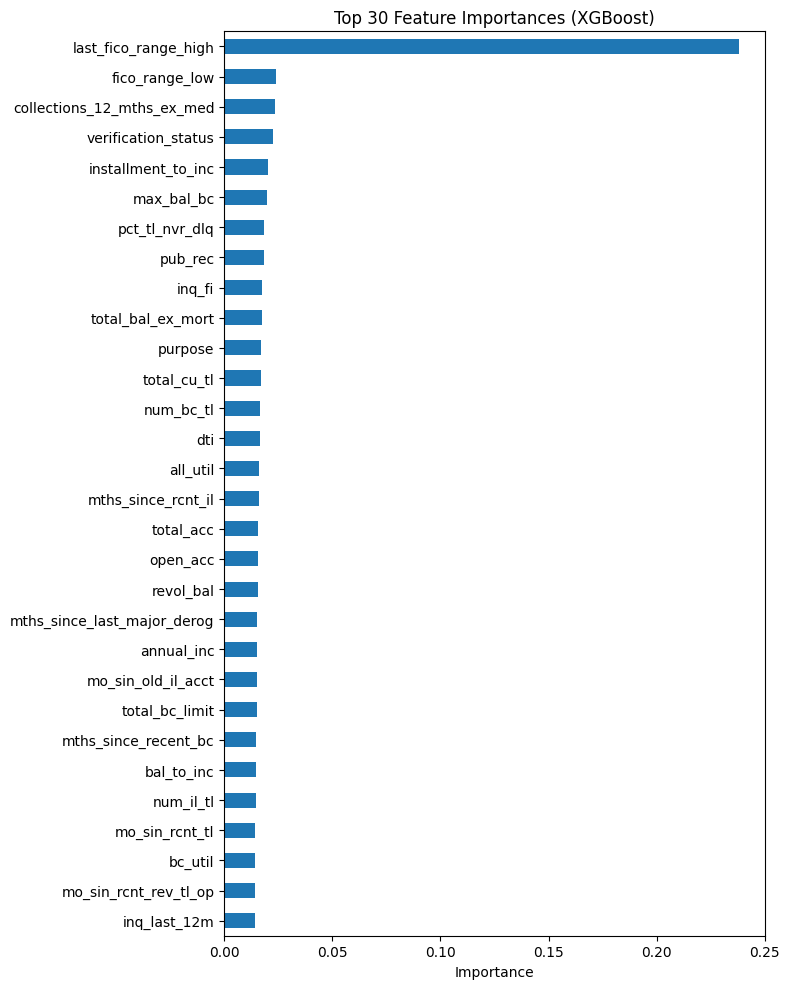

In [ ]:
feat_importance = pd.Series(
    xgb_clf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("Top features by importance:")
print(feat_importance)

# Optional: plot top 20 features
top_n = 30
plt.figure(figsize=(8, 10))
feat_importance.head(top_n).iloc[::-1].plot(kind="barh")
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
#creating new df containing the most important features across both methods of evaluating feature performance
important_df = df_pars_xgb[['target','last_fico_range_high', 'fico_range_low', 'installment_to_inc', 'collections_12_mths_ex_med', 'total_bc_limit', 'total_acc', 'mo_sin_old_il_acct', 'revol_bal', 'mths_since_last_major_derog', 'pct_tl_nvr_dlq', 'mths_since_last_record', 'earliest_cr_line_years', 'verification_status', 'max_bal_bc', 'pub_rec', 'inq_fi', 'purpose']]

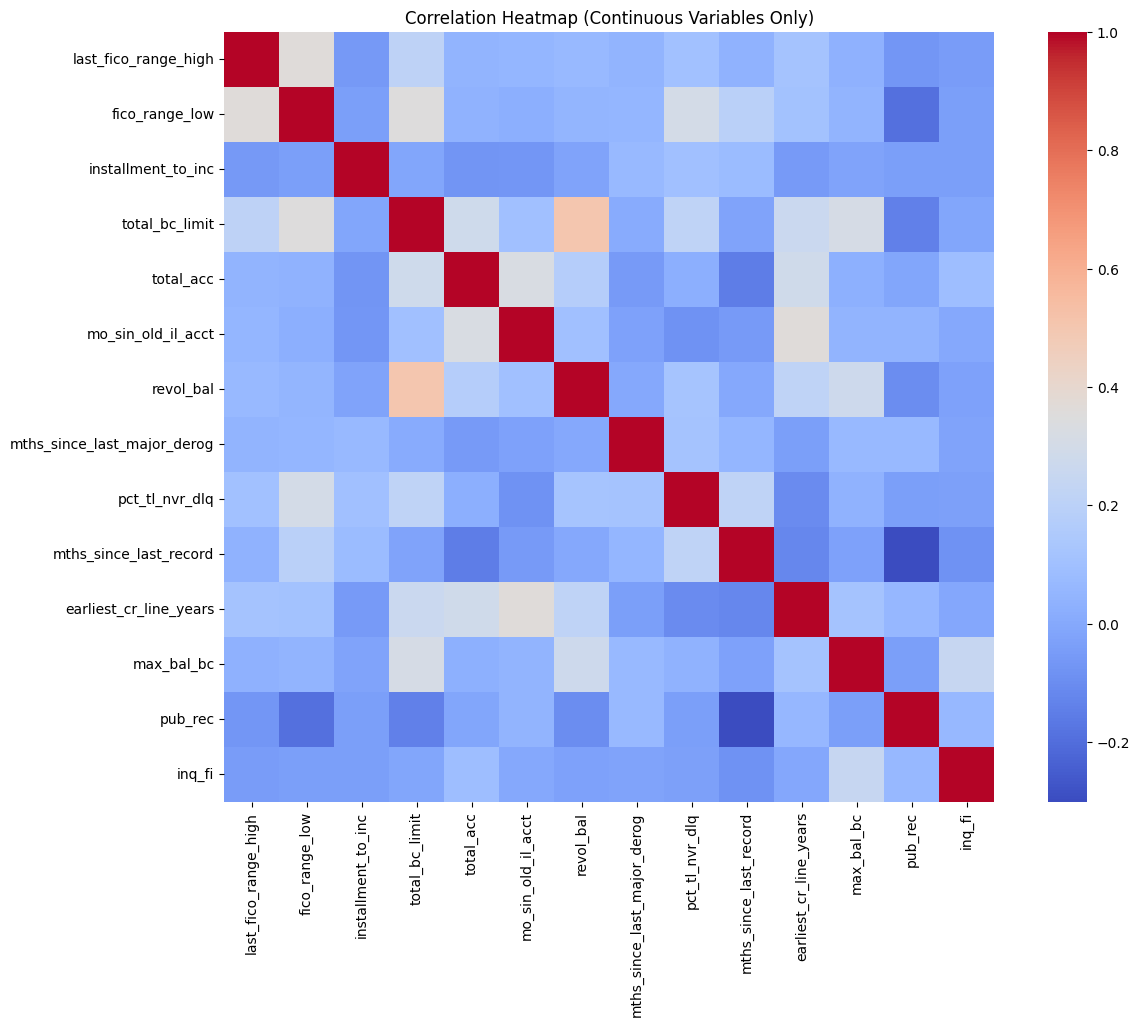

In [ ]:
#re-visualizing correlated variables
# 1. Narrow down continuous variables
continuous_df = important_df.select_dtypes(include=['float64', 'int64']).copy()

# 2. Drop likely categorical integer columns (optional)
to_drop = []

# Drop obvious identifiers if present
id_like = ['id', 'member_id', 'loan_id']
for col in id_like:
    if col in continuous_df.columns:
        to_drop.append(col)

# Drop columns with too few unique values (e.g., 0/1, enums)
for col in continuous_df.columns:
    if continuous_df[col].nunique() <= 5:
        to_drop.append(col)

continuous_df = continuous_df.drop(columns=set(to_drop), errors='ignore')

# 3. Compute correlation matrix
corr = continuous_df.corr()

# 4. Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
plt.title("Correlation Heatmap (Continuous Variables Only)")
plt.show()

# XGBoost Modeling with parsimonious dataset





In [ ]:
#copying df and counting rows
df_xgb = important_df.copy()
print(df_xgb.shape)
print(df_xgb.columns.tolist())

(11511, 18)
['target', 'last_fico_range_high', 'fico_range_low', 'installment_to_inc', 'collections_12_mths_ex_med', 'total_bc_limit', 'total_acc', 'mo_sin_old_il_acct', 'revol_bal', 'mths_since_last_major_derog', 'pct_tl_nvr_dlq', 'mths_since_last_record', 'earliest_cr_line_years', 'verification_status', 'max_bal_bc', 'pub_rec', 'inq_fi', 'purpose']


In [ ]:
# Split X / y
y = df_xgb["target"]
X = df_xgb.drop(columns=["target"])

In [ ]:
# 1) Build pipeline

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from xgboost import XGBClassifier
import numpy as np

# ---------------------------
# 0) Train / validation split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

#weighting
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("neg:", neg, "pos:", pos, "scale_pos_weight:", scale_pos_weight)




# ---------------------------
# 1) Base pipeline
# ---------------------------
pipe = Pipeline(steps=[
    ("model", XGBClassifier(
        tree_method="hist",          # required for categorical support
        enable_categorical=True,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# ---------------------------
# 2) Hyperparameter grid
# ---------------------------
param_distributions = {
    "model__n_estimators":      [100, 150, 200, 250],
    "model__max_depth":         [3, 4, 5, 6, 8],
    "model__min_child_weight":  [1, 2, 3, 5],
    "model__subsample":         [0.7, 0.85, 1.0],
    "model__colsample_bytree":  [0.6, 0.8, 1.0],
    "model__gamma":             [0, 0.5, 1, 2],
    "model__reg_alpha":         [0, 0.1, 0.5, 1.0],
    "model__reg_lambda":        [0.5, 1.0, 3.0, 5.0],
    "model__learning_rate":     [0.02, 0.05, 0.1],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=60,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    refit=True   # refits best model on *X_train, y_train*
)

# Fit only on training split
rand.fit(X_train, y_train)

print("Best CV AUC (on training folds):", rand.best_score_)
print("Best params:\n", rand.best_params_)

best_model = rand.best_estimator_  # already fit on X_train, y_train

# ---------------------------
# 3) Training-set metrics
# ---------------------------
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred  = (y_train_proba >= 0.5).astype(int)

train_auc   = roc_auc_score(y_train, y_train_proba)
train_acc   = accuracy_score(y_train, y_train_pred)
train_prec  = precision_score(y_train, y_train_pred)
train_recall= recall_score(y_train, y_train_pred)
train_f1    = f1_score(y_train, y_train_pred)

print("\n=== Training metrics (on X_train) ===")
print(f"AUC:        {train_auc:.4f}")
print(f"Accuracy:   {train_acc:.4f}")
print(f"Precision:  {train_prec:.4f}")
print(f"Recall:     {train_recall:.4f}")
print(f"F1:         {train_f1:.4f}")

# Optional: detailed report
# print("\nTraining classification report:")
# print(classification_report(y_train, y_train_pred))

# ---------------------------
# 4) Validation (hold-out) metrics
# ---------------------------
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred  = (y_val_proba >= 0.5).astype(int)

val_auc    = roc_auc_score(y_val, y_val_proba)
val_acc    = accuracy_score(y_val, y_val_pred)
val_prec   = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1     = f1_score(y_val, y_val_pred)

print("\n=== Validation metrics (hold-out X_val) ===")
print(f"AUC:        {val_auc:.4f}")
print(f"Accuracy:   {val_acc:.4f}")
print(f"Precision:  {val_prec:.4f}")
print(f"Recall:     {val_recall:.4f}")
print(f"F1:         {val_f1:.4f}")

neg: 7696 pos: 1512 scale_pos_weight: 5.08994708994709
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV AUC (on training folds): 0.940048736118575
Best params:
 {'model__subsample': 0.7, 'model__reg_lambda': 0.5, 'model__reg_alpha': 0, 'model__n_estimators': 150, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__gamma': 2, 'model__colsample_bytree': 1.0}

=== Training metrics (on X_train) ===
AUC:        0.9564
Accuracy:   0.8773
Precision:  0.5785
Recall:     0.9306
F1:         0.7135

=== Validation metrics (hold-out X_val) ===
AUC:        0.9434
Accuracy:   0.8723
Precision:  0.5686
Recall:     0.9206
F1:         0.7030


In [ ]:
#feature importance
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix)



##Model Evaluation

<Figure size 800x600 with 0 Axes>

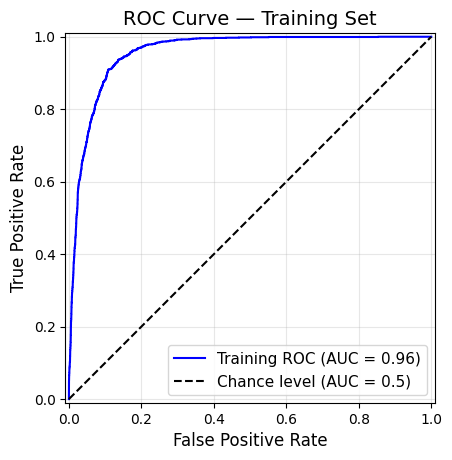

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# Compute AUCs (if not already computed)
train_auc = roc_auc_score(y_train, y_train_proba)
val_auc   = roc_auc_score(y_val, y_val_proba)

# ---------------------------
# TRAIN ROC — separate figure
# ---------------------------
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_train_proba,
    name=f"Training ROC",
    color="blue",
    plot_chance_level=True,
)

plt.title("ROC Curve — Training Set", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.show()



<Figure size 800x600 with 0 Axes>

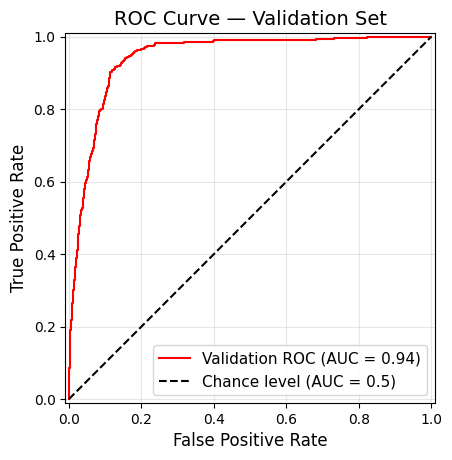

In [ ]:
# ---------------------------
# VALIDATION ROC
# ---------------------------
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_predictions(
    y_true=y_val,
    y_pred=y_val_proba,
    name=f"Validation ROC",
    color="red",
    plot_chance_level=True,
)

plt.title("ROC Curve — Validation Set", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.show()


###Feature Importance

                        feature  importance_mean  importance_std
0          last_fico_range_high         0.428650        0.018092
1            installment_to_inc         0.004548        0.000612
2                     total_acc         0.001328        0.000723
3                total_bc_limit         0.000926        0.000463
4                    max_bal_bc         0.000744        0.000411
5            mo_sin_old_il_acct         0.000710        0.000449
6           verification_status         0.000616        0.000498
7   mths_since_last_major_derog         0.000546        0.000266
8                pct_tl_nvr_dlq         0.000316        0.000462
9        earliest_cr_line_years         0.000207        0.000414
10       mths_since_last_record         0.000172        0.000149
11                       inq_fi         0.000099        0.000102
12   collections_12_mths_ex_med         0.000000        0.000000
13                    revol_bal        -0.000027        0.000453
14               fico_ran

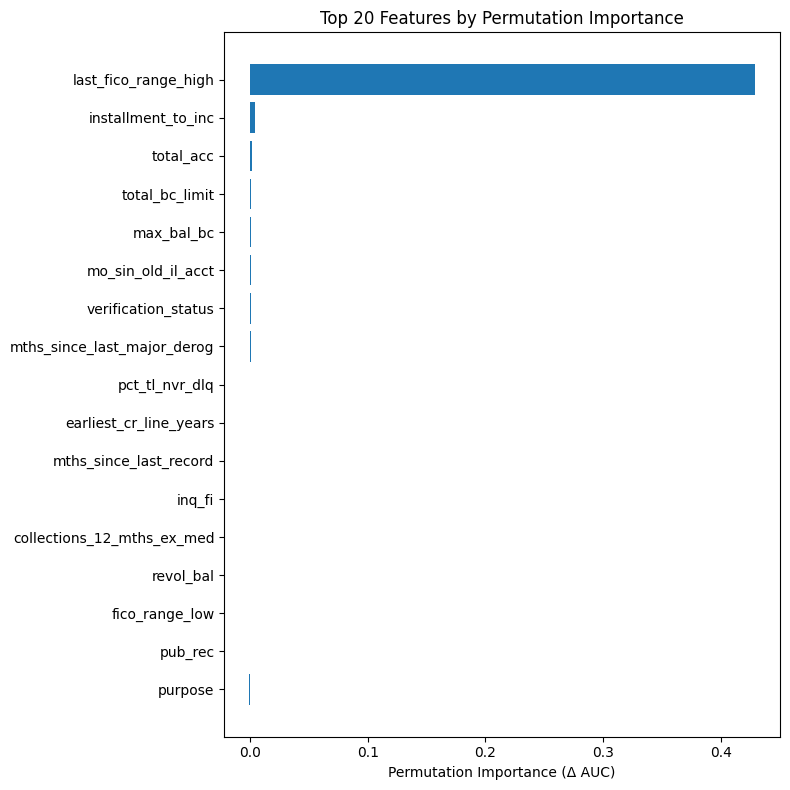

In [ ]:


# Permutation importance on the hold-out
r = permutation_importance(
    estimator=best_model,
    X=X_val,
    y=y_val,
    n_repeats=20,          # increase for more stable estimates
    scoring="roc_auc",     # use your task metric
    random_state=42,
    n_jobs=-1
)

# 4) Assemble a tidy DataFrame
imp_df = (
    pd.DataFrame({
        "feature": X_val.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

print(imp_df.head(25))  # top 25 features

# (Optional) Quick bar plot of top 20
import matplotlib.pyplot as plt

topn = 20
ax = imp_df.head(topn).iloc[::-1]  # reverse for horizontal plot
plt.figure(figsize=(8, 8))
plt.barh(ax["feature"], ax["importance_mean"])
plt.xlabel("Permutation Importance (Δ AUC)")
plt.title(f"Top {topn} Features by Permutation Importance")
plt.tight_layout()
plt.show()

###1D and 2D partial Dependence Analysis for most important features

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


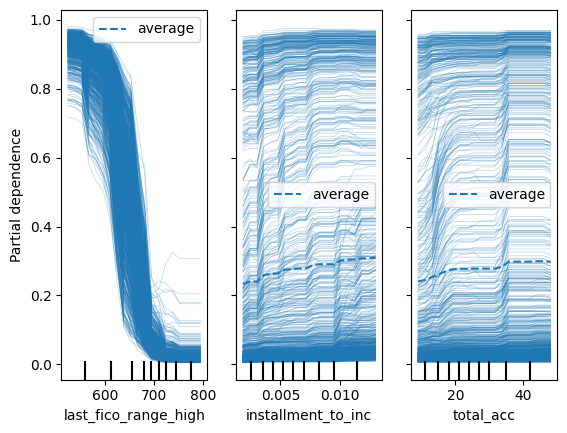

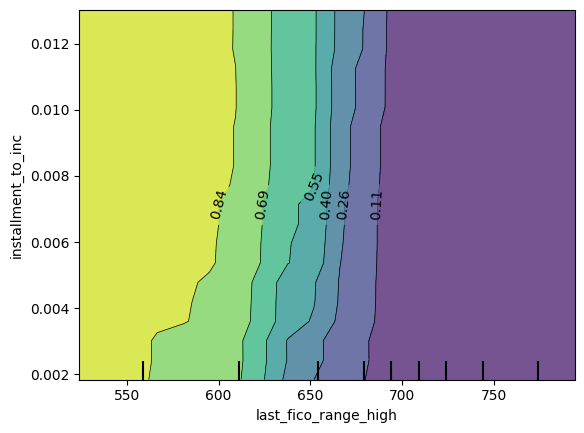

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
num_cols = X_val.select_dtypes(exclude=["object", "category"]).columns.tolist()

# Example: pick a few key numeric features (replace with your top ones)
features_1d = ["last_fico_range_high", "installment_to_inc", "total_acc"]
features_1d = [f for f in features_1d if f in num_cols]  # keep only those present/numeric

# Optional 2D interaction pairs (both should be numeric)
features_2d = [("last_fico_range_high", "installment_to_inc")]
features_2d = [pair for pair in features_2d
               if pair[0] in num_cols and pair[1] in num_cols]

# For speed, you can analyze a sample of the validation set
X_val_small = X_val.sample(n=min(2000, len(X_val)), random_state=42)

# ---------------------------
# 2) 1D PDP (with ICE lines)
# ---------------------------
PartialDependenceDisplay.from_estimator(
    estimator=best_model,
    X=X_val_small,
    features=features_1d,
    kind="both",                # "average", "individual", or "both" (PDP + ICE)
    grid_resolution=20,         # increase for smoother curves (slower)
    response_method="auto",     # uses predict_proba for classifiers
    n_jobs=-1                   # parallelize across features/grids
)

# ---------------------------
# 3) 2D PDP (interactions)
# ---------------------------
if features_2d:
    PartialDependenceDisplay.from_estimator(
        estimator=best_model,
        X=X_val_small,
        features=features_2d,   # list of tuples
        kind="average",
        grid_resolution=20,
        response_method="auto",
        n_jobs=-1
    )

###Evaluating Global Explanability with SHAP barplots and beeswarm plots

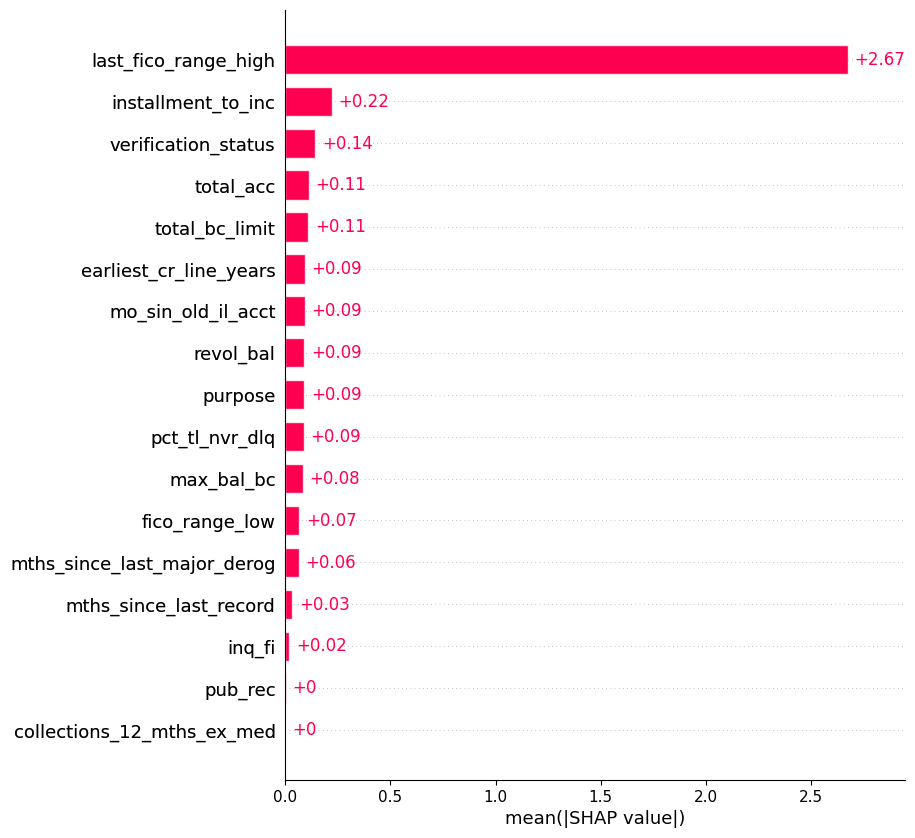

In [ ]:
import shap



# 1) Pull the underlying XGBClassifier out of the pipeline
xgb_clf = best_model.named_steps["model"]  # adjust if your step name differs

# 2) Build a TreeExplainer (fast, exact for trees)
explainer = shap.TreeExplainer(xgb_clf)

# 3) Compute SHAP values on your original features X
shap_values = explainer(X)            # X should be the same columns used to train

# 4) Bar plot of mean |SHAP| (feature importance)
shap.plots.bar(shap_values, max_display=20)
plt.show()



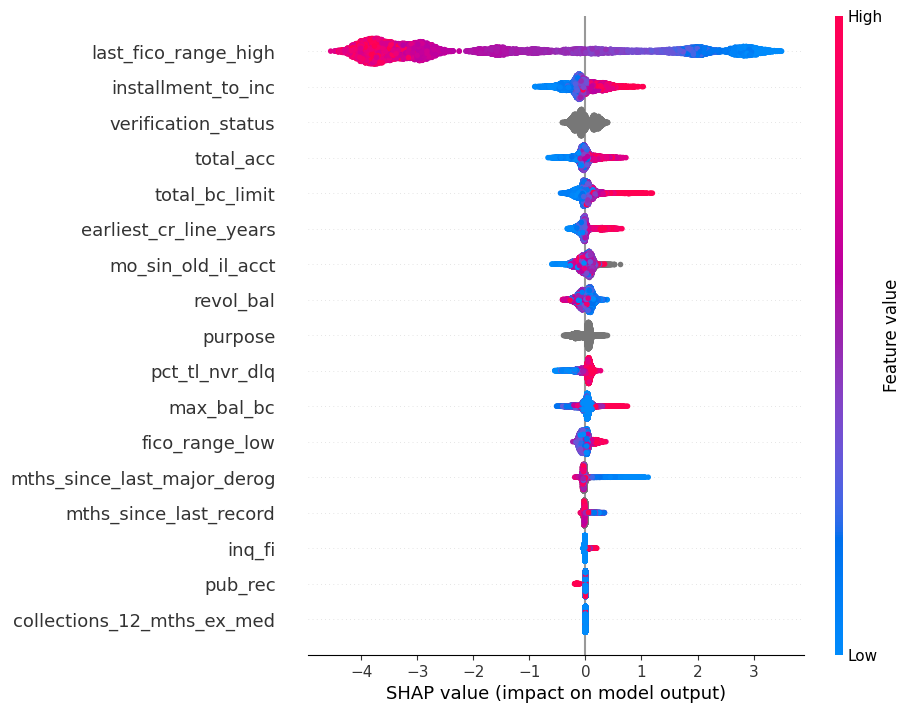

In [ ]:
# Global interpretability: SHAP swarm / beeswarm plot
shap.plots.beeswarm(shap_values, max_display=30)  # adjust max_display as you like
plt.show()


### Evaluating Local explainability with SHAP waterfall Plots

Waterfall plot 1 for observation index 10985


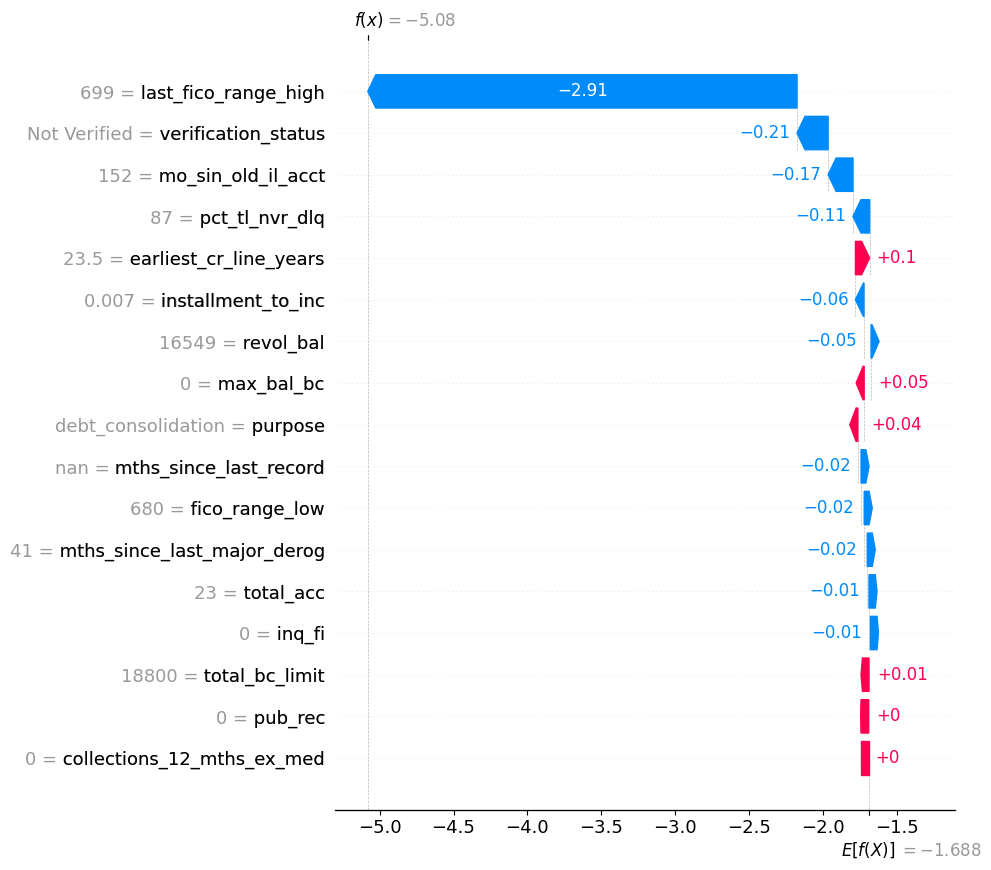

Waterfall plot 2 for observation index 11295


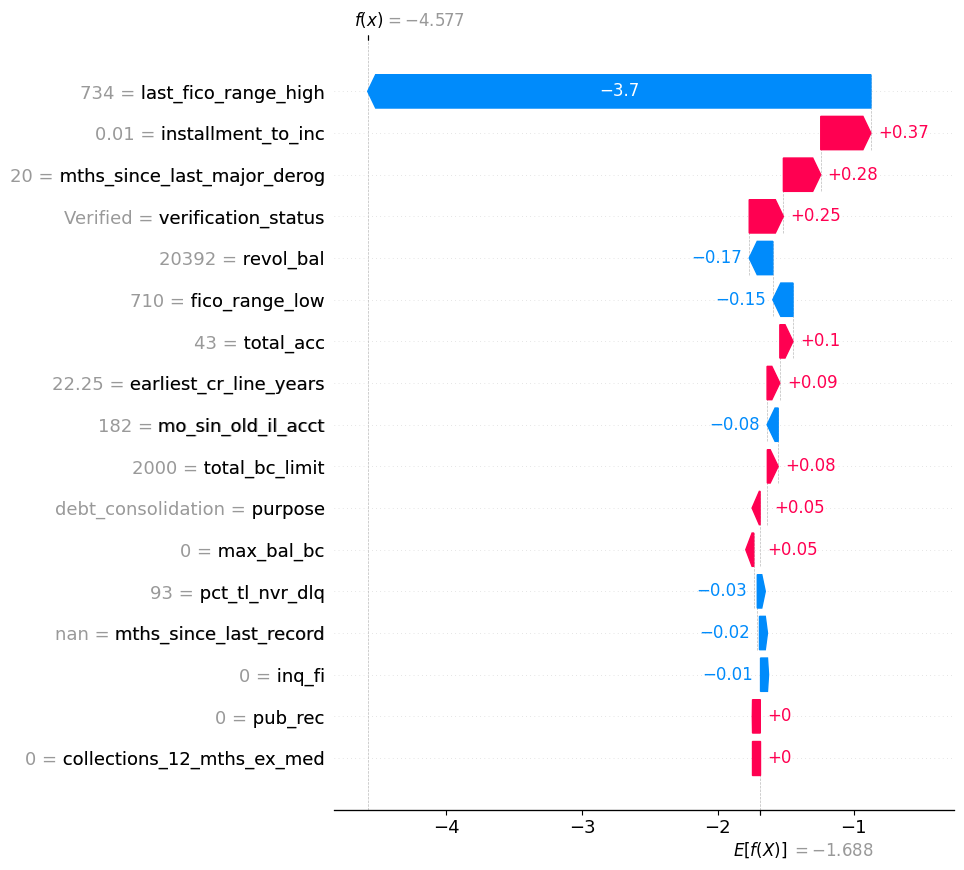

Waterfall plot 3 for observation index 3745


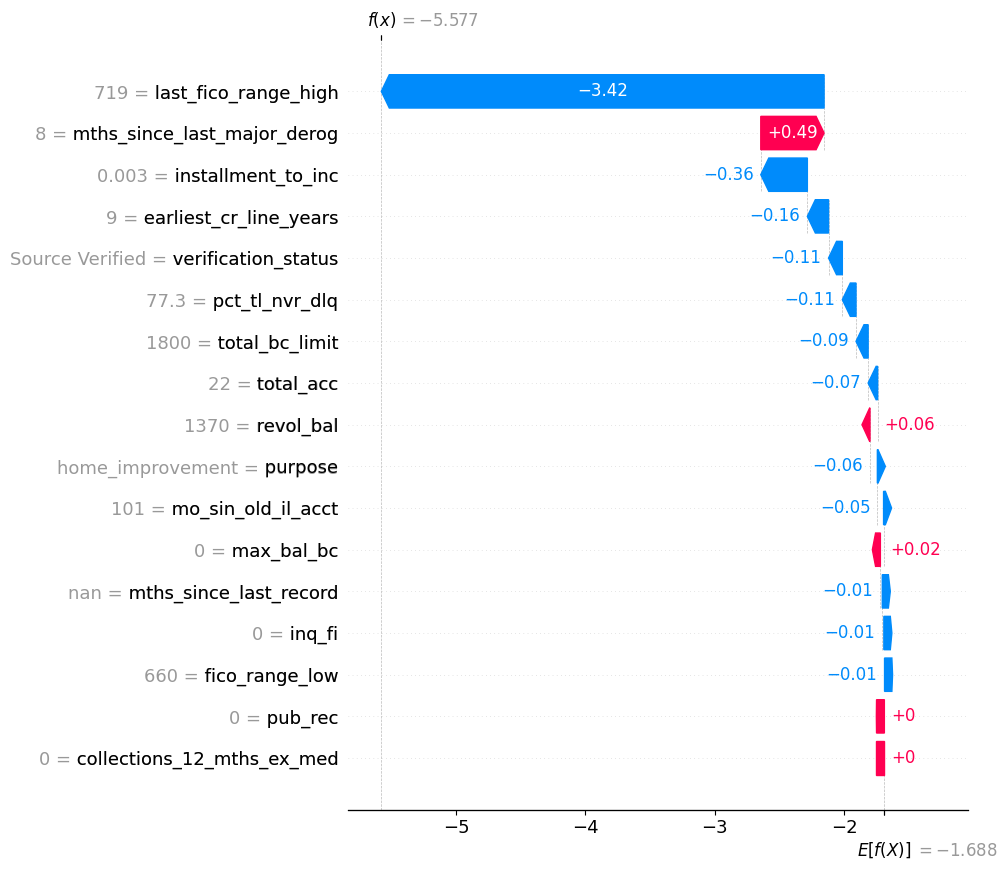

In [ ]:
# Choose 3 random row indices from X
np.random.seed(42)  # for reproducibility
random_indices = np.random.choice(X.shape[0], size=3, replace=False)

for i, idx in enumerate(random_indices, start=1):
    print(f"Waterfall plot {i} for observation index {idx}")

    # Select the SHAP explanation for a single observation
    single_explanation = shap_values[idx]   # this returns a 1-row Explanation

    # Waterfall plot for that observation
    shap.plots.waterfall(single_explanation, max_display=20)
    plt.show()

###Analysis of the 'Purpose' Feature

               purpose  avg_pred  delta_vs_baseline
10      small_business  0.182055           0.014495
6              medical  0.181181           0.013621
9     renewable_energy  0.177015           0.009455
7               moving  0.176451           0.008891
12             wedding  0.175911           0.008351
11            vacation  0.175801           0.008241
2   debt_consolidation  0.171542           0.003981
4                house  0.168335           0.000775
5       major_purchase  0.164476          -0.003084
0                  car  0.164320          -0.003240
8                other  0.162740          -0.004820
3     home_improvement  0.156553          -0.011007
1          credit_card  0.152623          -0.014937


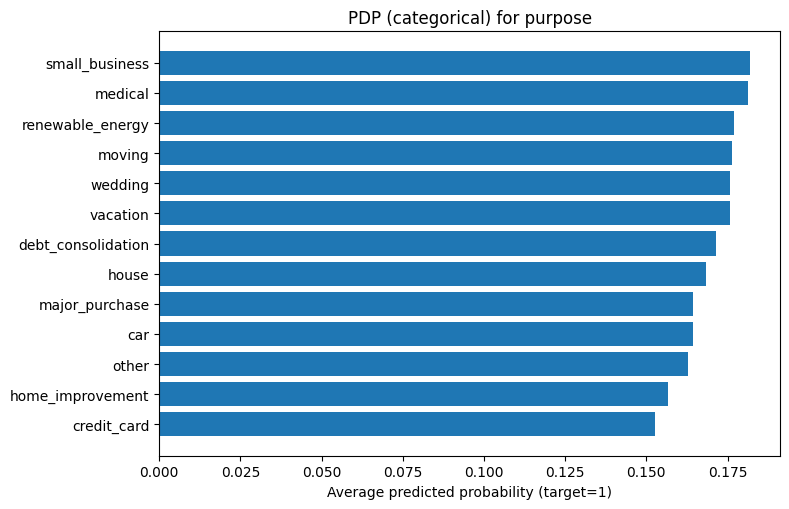

In [ ]:
import matplotlib.pyplot as plt

# Define the categorical column to analyze
purpose_col = 'purpose'

X_val_cat = X_val.copy()
X_val_cat[purpose_col] = X_val_cat[purpose_col].astype('category')
cats = X_val_cat[purpose_col].cat.categories

base = best_model.predict_proba(X_val_cat)[:, 1].mean()
rows = []
for c in cats:
    X_tmp = X_val_cat.copy()
    # assign as a Categorical to avoid object dtype
    X_tmp[purpose_col] = pd.Categorical(np.full(len(X_tmp), c), categories=cats)
    p = best_model.predict_proba(X_tmp)[:, 1].mean()
    rows.append((c, p, p - base))

pdp_df = (pd.DataFrame(rows, columns=[purpose_col, 'avg_pred', 'delta_vs_baseline'])
          .sort_values('avg_pred', ascending=False))
print(pdp_df)

plt.figure(figsize=(8, max(3, 0.4*len(pdp_df))))
plt.barh(pdp_df[purpose_col][::-1], pdp_df['avg_pred'][::-1])
plt.xlabel('Average predicted probability (target=1)')
plt.title(f"PDP (categorical) for {purpose_col}")
plt.tight_layout(); plt.show()

###Probability Calibration Analysis

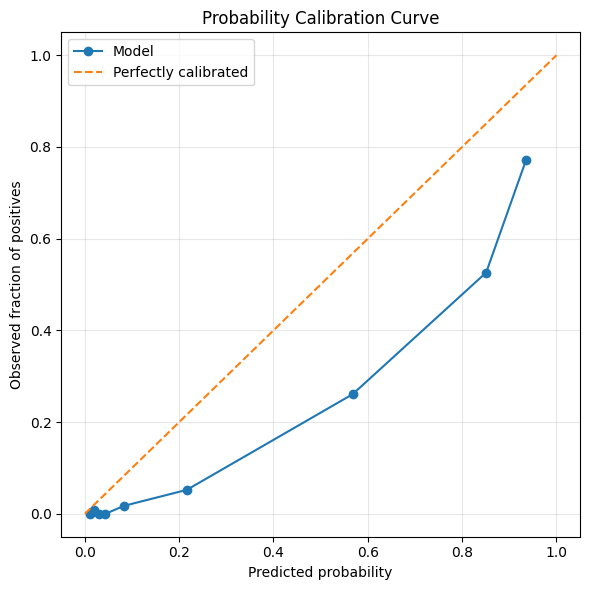

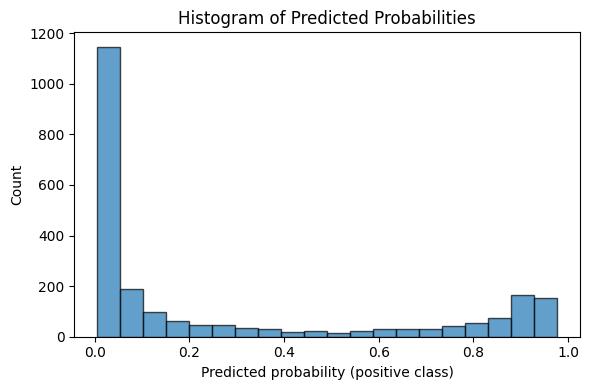

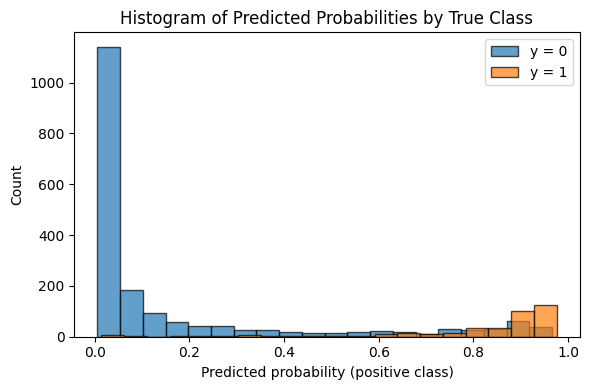

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# 1) Get predicted probabilities on the validation set
val_proba = best_model.predict_proba(X_val)[:, 1]

# 2) Calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(
    y_val,
    val_proba,
    n_bins=10,          # you can tweak this
    strategy="quantile" # bins with roughly equal number of samples
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", linestyle="-", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("Observed fraction of positives")
plt.title("Probability Calibration Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Probability calibration histogram (distribution of predicted probs)
plt.figure(figsize=(6, 4))
plt.hist(val_proba, bins=20, edgecolor="k", alpha=0.7)
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Count")
plt.title("Histogram of Predicted Probabilities")
plt.tight_layout()
plt.show()

# (Optional) separate histograms by true class
plt.figure(figsize=(6, 4))
plt.hist(val_proba[y_val == 0], bins=20, alpha=0.7, edgecolor="k", label="y = 0")
plt.hist(val_proba[y_val == 1], bins=20, alpha=0.7, edgecolor="k", label="y = 1")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Count")
plt.title("Histogram of Predicted Probabilities by True Class")
plt.legend()
plt.tight_layout()
plt.show()


## Random Forest Baseline Model


###Modeling Pipeline

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# ---------------------------
# 1) X / y
# ---------------------------
y = df_xgb["target"].astype(int)
X = df_xgb.drop(columns=["target"], errors="ignore").copy()

# Identify column types
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    X[cat_cols] = X[cat_cols].astype("category")

# ---------------------------
# 2) Preprocessing
#    - Numeric: median impute
#    - Categorical: mode impute + OHE (ignore unseen categories)
# ---------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop",
)

# ---------------------------
# 3) Random Forest (good defaults, no tuning)
# ---------------------------
rf = RandomForestClassifier(
    n_estimators=600,               # solid default for stability
    max_depth=12,                   # curb overfitting/speed up
    min_samples_leaf=2,             # smoother splits
    min_samples_split=10,
    max_features="sqrt",            # standard for classification
    class_weight="balanced_subsample",  # handle imbalance
    bootstrap=True,
    n_jobs=-1,                      # use all cores (safe since no CV grid)
    random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", rf)])

# ---------------------------
# 4) 5-fold CV (metrics) — no tuning, just report
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision"}

cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
print(f"CV ROC-AUC: {np.mean(cv_res['test_roc_auc']):.4f} ± {np.std(cv_res['test_roc_auc']):.4f}")
print(f"CV PR-AUC : {np.mean(cv_res['test_pr_auc']):.4f} ± {np.std(cv_res['test_pr_auc']):.4f}")

# ---------------------------
# 5) Fit final model on ALL data (for deployment/inference)
# ---------------------------
pipe.fit(X, y)

# ---------------------------
# 6) (Optional) Feature importances with names
# ---------------------------
feat_names = pipe.named_steps["pre"].get_feature_names_out()
importances = pipe.named_steps["clf"].feature_importances_
imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True))
print(imp_df.head(25))

CV ROC-AUC: 0.9335 ± 0.0030
CV PR-AUC : 0.6943 ± 0.0145
                                     feature  importance
0                  num__last_fico_range_high    0.707812
1                    num__installment_to_inc    0.040204
2                        num__fico_range_low    0.036222
3                        num__total_bc_limit    0.026614
4                             num__revol_bal    0.026424
5                num__earliest_cr_line_years    0.024126
6                    num__mo_sin_old_il_acct    0.023697
7                             num__total_acc    0.022526
8                        num__pct_tl_nvr_dlq    0.018198
9           num__mths_since_last_major_derog    0.012562
10                           num__max_bal_bc    0.011767
11     cat__verification_status_Not Verified    0.009023
12               num__mths_since_last_record    0.008273
13         cat__verification_status_Verified    0.005871
14                               num__inq_fi    0.004973
15                  cat__purpose

###Validation

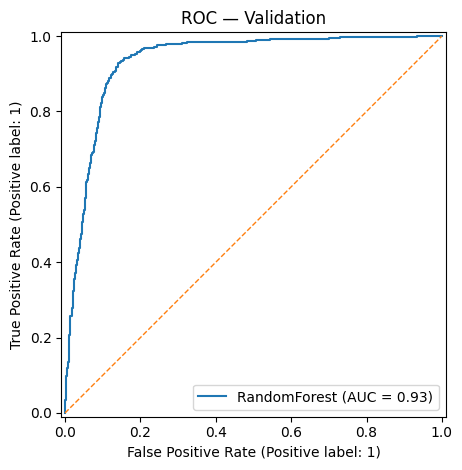

Hold-out ROC-AUC: 0.9346512746512746


In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Hold-out split
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 1) Fit on train
pipe.fit(X_tr, y_tr)

# 2) ROC curve on validation
RocCurveDisplay.from_estimator(
    estimator=pipe, X=X_va, y=y_va, name="RandomForest"
)
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.title("ROC — Validation")
plt.tight_layout()
plt.show()

# (optional: print the numeric AUC)
y_score = pipe.predict_proba(X_va)[:, 1]
print("Hold-out ROC-AUC:", roc_auc_score(y_va, y_score))

###Feature importance

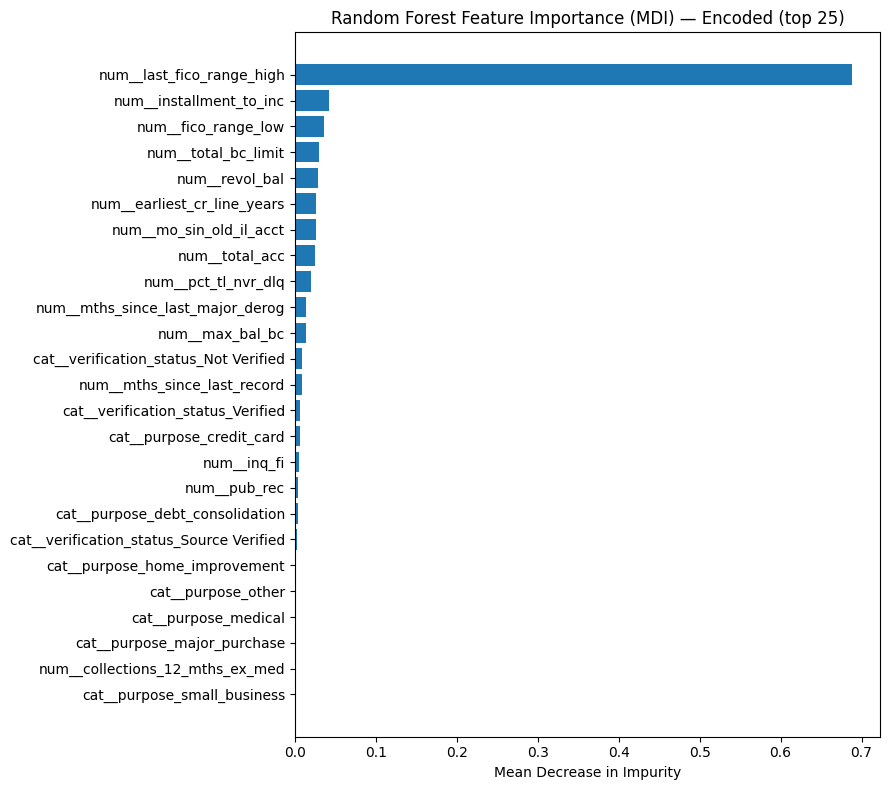

                                 feature_raw  importance
0                       last_fico_range_high    0.688405
1                         installment_to_inc    0.042485
2                             fico_range_low    0.035710
3                             total_bc_limit    0.030240
4                                  revol_bal    0.028318
5                     earliest_cr_line_years    0.026440
6                         mo_sin_old_il_acct    0.025698
7                                  total_acc    0.024137
8                             pct_tl_nvr_dlq    0.019345
9                mths_since_last_major_derog    0.013570
10                                max_bal_bc    0.013323
11     cat__verification_status_Not Verified    0.008365
12                    mths_since_last_record    0.008222
13         cat__verification_status_Verified    0.006798
14                  cat__purpose_credit_card    0.005837
15                                    inq_fi    0.005051
16                             

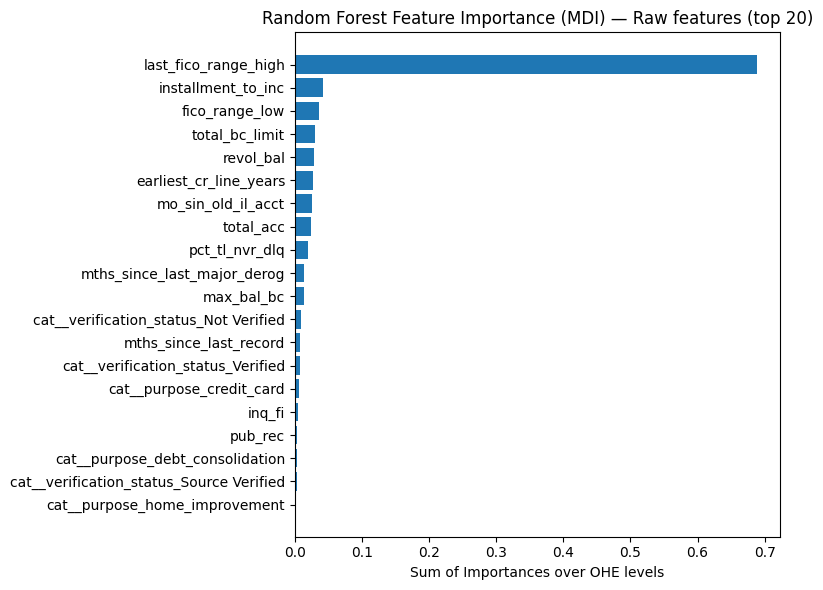

In [ ]:
# 1) Get encoded feature names + importances
pre = pipe.named_steps["pre"]
rf  = pipe.named_steps["clf"]

feat_names = pre.get_feature_names_out()          # e.g., ["num__int_rate", "cat__ohe__purpose_debt_consolidation", ...]
importances = rf.feature_importances_

imp_enc = (pd.DataFrame({"feature_enc": feat_names, "importance": importances})
             .sort_values("importance", ascending=False)
             .reset_index(drop=True))

# --- Plot (encoded features): top 25
topn = 25
ax_df = imp_enc.head(topn).iloc[::-1]
plt.figure(figsize=(9, 8))
plt.barh(ax_df["feature_enc"], ax_df["importance"])
plt.title(f"Random Forest Feature Importance (MDI) — Encoded (top {topn})")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()

# 2) (Optional) Aggregate OHE columns back to their original feature
def base_feature(name: str) -> str:
    if name.startswith("num__"):
        return name.split("num__", 1)[1]
    if name.startswith("cat__ohe__"):
        rest = name.split("cat__ohe__", 1)[1]
        # OHE names look like "<feature>_<category>"; take everything before the last "_"
        return rest.rsplit("_", 1)[0] if "_" in rest else rest
    # fallback
    return name

imp_enc["feature_raw"] = imp_enc["feature_enc"].map(base_feature)

imp_raw = (imp_enc.groupby("feature_raw", as_index=False)["importance"]
                 .sum()
                 .sort_values("importance", ascending=False)
                 .reset_index(drop=True))

print(imp_raw.head(20))  # table view

# --- Plot (raw/original features): top 20
topn_raw = 20
ax_df2 = imp_raw.head(topn_raw).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(ax_df2["feature_raw"], ax_df2["importance"])
plt.title(f"Random Forest Feature Importance (MDI) — Raw features (top {topn_raw})")
plt.xlabel("Sum of Importances over OHE levels")
plt.tight_layout()
plt.show()

###Global explainability with SHAP plots

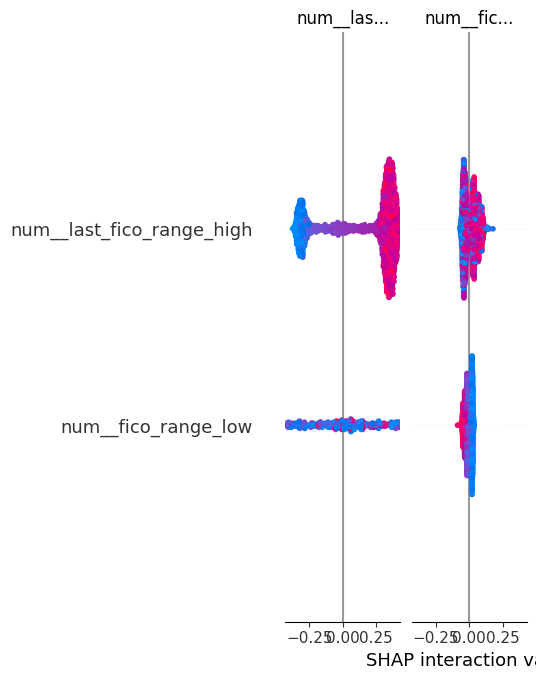

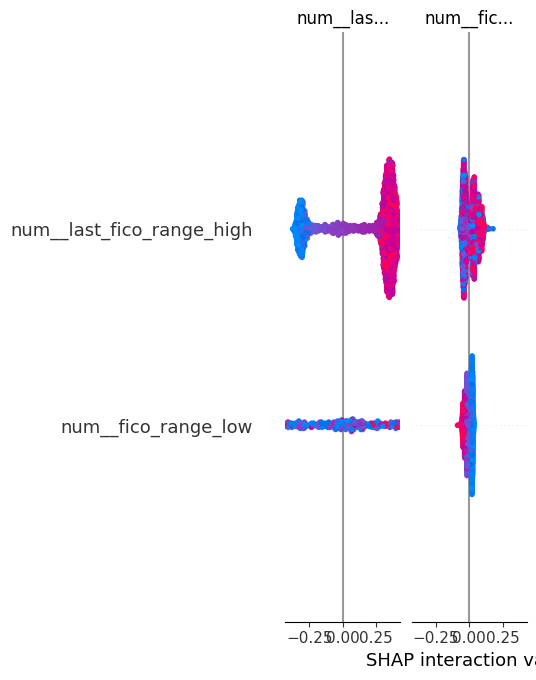

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (31, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
import shap
Xv_trans = pre.transform(X_va)                       # numpy array
feat_names = pre.get_feature_names_out()

# 2) Build TreeExplainer and compute SHAP values on the transformed matrix
explainer = shap.TreeExplainer(rf)
shap_vals_raw = explainer.shap_values(Xv_trans)

# Handle binary vs multiclass return types
if isinstance(shap_vals_raw, list):
    shap_vals = shap_vals_raw[1]                     # positive class
    base_value = explainer.expected_value[1]
else:
    shap_vals = shap_vals_raw                        # (n_samples, n_features)
    base_value = explainer.expected_value

# 3) GLOBAL PLOTS
# (Optional) subsample for speed on very large sets
max_rows = 5000
if Xv_trans.shape[0] > max_rows:
    rng = np.random.default_rng(0)
    idx = rng.choice(Xv_trans.shape[0], size=max_rows, replace=False)
    X_plot = Xv_trans[idx]
    sv_plot = shap_vals[idx]
else:
    X_plot = Xv_trans
    sv_plot = shap_vals

# Beeswarm: distribution of SHAP values across observations
shap.summary_plot(sv_plot, X_plot, feature_names=feat_names)

# Bar: mean(|SHAP|) importance
shap.summary_plot(sv_plot, X_plot, feature_names=feat_names, plot_type="bar")

# 4) LOCAL WATERFALL for the highest predicted probability row
y_proba_va = pipe.predict_proba(X_va)[:, 1]
top_idx_label = pd.Series(y_proba_va, index=X_va.index).sort_values(ascending=False).index[0]
pos = X_va.index.get_loc(top_idx_label)

# Safely extract scalar base value
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = float(base_value[1] if len(np.atleast_1d(base_value)) > 1 else base_value[0])

# Then build the explanation
exp = shap.Explanation(
    values=sv_plot[pos],
    base_values=base_value,
    data=Xv_trans[pos],
    feature_names=feat_names
)

shap.plots.waterfall(exp, max_display=20)

# (sanity check) SHAP margin -> probability vs model.proba
print("Top row index label:", top_idx_label)
print("predict_proba:", float(y_proba_va[pos]))
print("from SHAP   :", float(expit(float(base_value) + float(sv_plot[pos].sum()))))

###Local explainability with SHAP plots

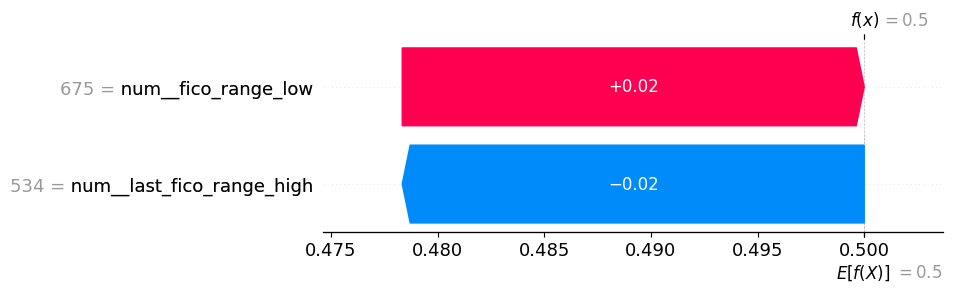

Top row index label: 14185
predict_proba: 0.908082599006118
from SHAP   : 0.6224593312018558


In [ ]:
import numpy as np
import pandas as pd
import shap
from scipy.special import expit

# --- 1) Transform validation set & get names (what RF actually sees) ---
pre = pipe.named_steps["pre"]
clf = pipe.named_steps["clf"]
Xv_trans = pre.transform(X_va)                 # numpy array
feat_names = pre.get_feature_names_out()

# --- 2) SHAP values (RandomForest -> TreeExplainer) ---
explainer = shap.TreeExplainer(clf)
sv_raw = explainer.shap_values(Xv_trans)       # can be array OR list depending on versions
ev_raw = explainer.expected_value

# --- 3) Coerce to (n_samples, n_features) for the POSITIVE class ---
def coerce_binary_shap(sv, ev):
    # list case: [class0, class1]
    if isinstance(sv, list):
        sv_pos = np.asarray(sv[1])
        base = ev[1] if isinstance(ev, (list, np.ndarray)) else ev
    else:
        arr = np.asarray(sv)
        # shape (n_samples, n_classes, n_features)
        if arr.ndim == 3 and arr.shape[1] >= 2:
            sv_pos = arr[:, 1, :]
            base = ev[1] if isinstance(ev, (list, np.ndarray)) else ev
        # shape (n_samples, n_features)
        elif arr.ndim == 2:
            sv_pos = arr
            base = ev[0] if isinstance(ev, (list, np.ndarray)) else ev
        else:
            raise ValueError(f"Unexpected shap_values shape: {arr.shape}")
    base = float(np.ravel(base)[0])  # ensure scalar
    return sv_pos, base

sv_pos, base_value = coerce_binary_shap(sv_raw, ev_raw)

# --- 4) Choose the SINGLE row with the highest predicted probability ---
y_proba = pipe.predict_proba(X_va)[:, 1]
pos = int(np.argmax(y_proba))                 # positional index in X_va / Xv_trans

# --- 5) Build a single Explanation and plot WATERFALL (now 1D values) ---
exp = shap.Explanation(
    values=sv_pos[pos],                       # shape: (n_features,)
    base_values=base_value,                   # scalar
    data=Xv_trans[pos],                       # transformed row
    feature_names=feat_names
)
shap.plots.waterfall(exp, max_display=20)

# (Optional) sanity check: margin -> prob vs model proba
print("Top row index label:", X_va.index[pos])
print("predict_proba:", float(y_proba[pos]))
print("from SHAP   :", float(expit(base_value + sv_pos[pos].sum())))


###Probability Calibration Analysis

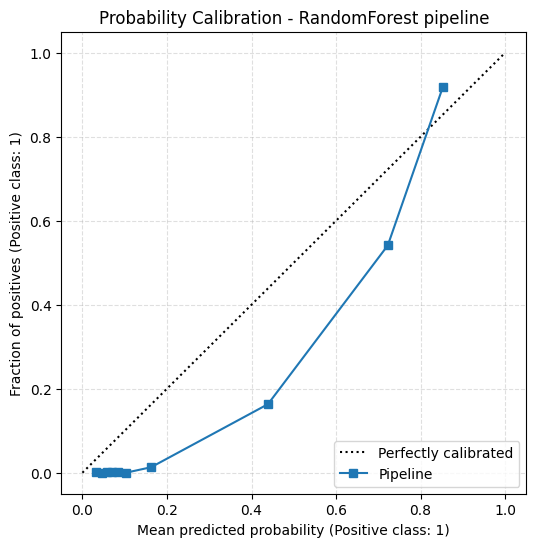

In [ ]:
from sklearn.calibration import CalibrationDisplay

# Calibration curve using the estimator directly
fig, ax = plt.subplots(figsize=(6, 6))

CalibrationDisplay.from_estimator(
    estimator=pipe,
    X=X,
    y=y,
    n_bins=10,          # you can tweak this
    strategy="quantile",
    ax=ax
)

ax.set_title("Probability Calibration - RandomForest pipeline")
ax.grid(True, linestyle="--", alpha=0.4)
plt.show()

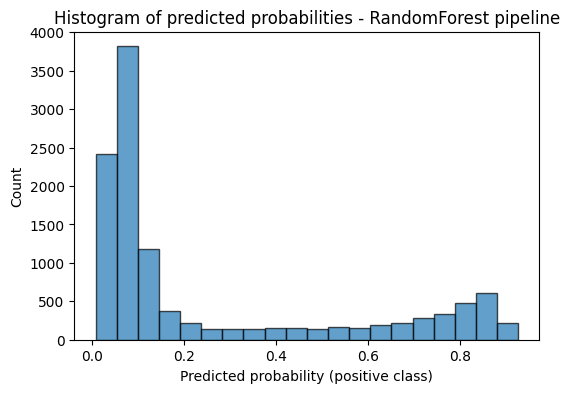

In [ ]:
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_proba = pipe.predict_proba(X)[:, 1]

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(y_proba, bins=20, edgecolor="black", alpha=0.7)
ax.set_xlabel("Predicted probability (positive class)")
ax.set_ylabel("Count")
ax.set_title("Histogram of predicted probabilities - RandomForest pipeline")
plt.show()
